# Chemprot Shortcut analysis

In [1]:
s3_test_prediction = "s3://aegovan-data/chemprot/predictions_chemprot-bert-f1-2022-05-22-23-18-21-560/prediction_chemprot_test.json"
s3_train_prediction = "s3://aegovan-data/chemprot/predictions_chemprot-bert-f1-2022-05-22-23-18-21-560/prediction_chemprot_train.json"
s3_val_prediction = "s3://aegovan-data/chemprot/predictions_chemprot-bert-f1-2022-05-22-23-18-21-560/prediction_chemprot_dev.json"



participants_to_replace = {
    "_GENE-Y_" : "_GENE_",
    "_GENE-N_" : "_GENE_"
}



x_column = "sentence_anonymised"
gold_y_column = "label"
prediction_y_column = "prediction"




In [2]:
s3_test_prediction ="s3://aegovan-data/chemprot/predictions_chemprot-abstract-bert-f1-2022-07-30-22-34-07-969/prediction_chemprot_abstract_test_marker.json"
s3_val_prediction ="s3://aegovan-data/chemprot/predictions_chemprot-abstract-bert-f1-2022-07-30-22-34-07-969/prediction_chemprot_abstract_val_marker.json"
s3_train_prediction ="s3://aegovan-data/chemprot/predictions_chemprot-abstract-bert-f1-2022-07-30-22-34-07-969/prediction_chemprot_abstract_train_marker.json"

s3_largescale_high_quality_prediction = "s3://aegovan-data/chemprot/predictions_chemprot-abstract-bert-f1-2022-07-30-22-34-07-969/2022080621_negative_generalisation/highquality_sample.json"
s3_largescale_low_quality_prediction = "s3://aegovan-data/chemprot/predictions_chemprot-abstract-bert-f1-2022-07-30-22-34-07-969/2022080621_negative_generalisation/lowquality_sample.json"




x_column = "x"
gold_y_column = "y_raw"
prediction_y_column = "prediction"
participants_to_replace = {
    "GENEPART0" : "_GENE_",
    "GENEPART1" : "_GENE_",
    "CHEMPART1" : "_CHEMICAL_",
    "CHEMPART0" : "_CHEMICAL_",


}


In [3]:
other_genes_to_replace = {f"GENEIG{i} ":"_OTHER_ " for i in range(20)}
other_chem_to_replace = {f"CHEMIG{i} ":"_OTHER_ " for i in range(20)}

other_ignore = {**other_genes_to_replace, **other_chem_to_replace}

# markers_to_replace = {**participants_to_replace, **other_ignore }
markers_to_replace = {**participants_to_replace}

In [4]:
markers_to_replace

{'GENEPART0': '_GENE_',
 'GENEPART1': '_GENE_',
 'CHEMPART1': '_CHEMICAL_',
 'CHEMPART0': '_CHEMICAL_'}

#### Get the gold dataset from https://biocreative.bioinformatics.udel.edu/media/store/files/2017/ChemProt_Corpus.zip

In [5]:
s3_test_gold_file = "s3://aegovan-data/chemprotner/test/chemprot_test_gold_standard.tsv"

In [6]:
import sys, pandas as pd, os, matplotlib.pyplot as plt, sklearn
from sklearn import tree

sys.path.append("../src")


label_names = ["NEGATIVE",
                            "CPR:3",
                            "CPR:4",
                            "CPR:5",
                            "CPR:6",
                            "CPR:9"]

all_labels = list(range(len(label_names)))
pos_labels = list(range(1, len(label_names)))

trigger_words =  ["induced", "activator","upregulator" , "inhibitor","downregulator" , "agonist", "kinase","regulator","modulator"]



In [7]:
import sys, os, pandas as pd
pd.set_option('display.max_colwidth',None)


sys.path.append("../src")

from utils.s3_utils import download_file as download_s3_file

## Download prediction

In [8]:
local_temp= "temp"

In [9]:
local_prediction_dir = os.path.join(local_temp, "prediction")
os.makedirs(local_prediction_dir, exist_ok=True)
local_test_prediction_file  = download_s3_file( s3_test_prediction, local_prediction_dir)
local_train_prediction_file  = download_s3_file( s3_train_prediction, local_prediction_dir)
local_val_prediction_file  = download_s3_file( s3_val_prediction, local_prediction_dir)
test_gold_file  = download_s3_file( s3_test_gold_file, local_prediction_dir)
local_highquality_file = download_s3_file(s3_largescale_high_quality_prediction, local_prediction_dir)
local_lowquality_file = download_s3_file(s3_largescale_low_quality_prediction, local_prediction_dir)





## Utils

In [10]:
def add_key_column(df):
    df["key"] = df.apply(lambda x:"{}#{}#{}".format( x["abstract_id"], x["participant1_id"].replace("Arg1:",""), x["participant2_id"].replace("Arg2:","")), axis=1)
    return df

def load_gold(file):
    df = pd.read_csv(file, delimiter="\t", header=None, names = ["abstract_id", "relationship_type", "participant1_id","participant2_id"])
    
    return df

In [11]:

def replace_in_place(x, replacement_dict):
    for k,v in replacement_dict.items():
        x = x.replace(k,v)
    return x
    

def load_valtest_pred(file, labels_order = label_names, markers_replacement=markers_to_replace):
    df = pd.read_json(file, orient="records")
    
    

    df["x"] = df[x_column].apply(lambda x: replace_in_place(x,markers_replacement))
    df["gold"] = df[gold_y_column].apply(lambda x: labels_order.index(x))
    df["gold_raw"] = df[gold_y_column]

    df["y"] = df[prediction_y_column].apply(lambda x: labels_order.index(x))
    df["y_raw"] = df[prediction_y_column]


    #df = df.query("is_eval == 'Y'").copy()

    return df

In [12]:
from model_nb_relation_classifier import ModelNBRelationClassifier
from model_nb_tree_relation_classifier import ModelNBTreeRelationClassifier
from model_tree_relation_classifier import ModelTreeRelationClassifier

NAIVE_BAYES="Naive Bayes"
NAIVE_BAYES_WITH_TREE = "Naive Bayes + Tree"
TREE = "Tree"

def  train_and_predict_all_classifiers(df, min_df=None, ngram_range=(1,1), stop_words = 'english', classifiers={NAIVE_BAYES, NAIVE_BAYES_WITH_TREE}, max_words_per_class=100, classwise_vocab=True):
    
    max_tree_depth = 4
    min_df = min_df or 3
    
    nb_kwargs = {
        "min_df": min_df,
        "max_words_per_class":max_words_per_class, 
        "stop_words": stop_words, 
        "ngram_range": ngram_range, 
        "classwise_vocab": classwise_vocab
    }
    
    classifiers_map = {
        NAIVE_BAYES : ModelNBRelationClassifier("_CHEMICAL_", "_GENE_", **nb_kwargs),
        NAIVE_BAYES_WITH_TREE : ModelNBTreeRelationClassifier("_CHEMICAL_", "_GENE_", trigger_words=trigger_words, max_tree_depth = max_tree_depth, extract_span=True, **nb_kwargs ),
      #  TREE : ModelTreeRelationClassifier("_CHEMICAL_", "_GENE_", trigger_words=trigger_words, max_tree_depth = max_tree_depth)

    }
    
    result = {}
    for k in filter(lambda x: x in classifiers,  classifiers_map):
    
        m = classifiers_map[k]
        
        print(f"Training {k}")
        
        m.train(df["x"], df["y"])
        p, p_conf = m.predict(df["x"])
        result[k] = {
            "m" : m,
            "predictions" : p,
             "predictions_conf": p_conf
        }
    return result


def  predict_all_classifiers(df, models_dict):
   
    
   
    
    result = {}
    for k, v in models_dict.items():
        m = v["m"]
        
        p, p_conf = m.predict(df["x"])
        result[k] = {
            "m" : m,
            "predictions" : p,
            "predictions_conf": p_conf
        }
    return result




In [13]:
import tempfile

def isint(a):
    try:
        t = int(a)
        return True
    except:
        return False

def float_percent_format(x):
     return "{:.1f}".format(x*100)

def int_format(x):
     return str(int(x))

def print_report(actual, pred, labels=None, label_names = all_labels):

    pos_f1 = sklearn.metrics.f1_score(actual, pred, labels=labels, average='micro',
                                  sample_weight=None, zero_division=0)
    all_f1 = sklearn.metrics.f1_score(actual, pred, average='micro', sample_weight=None, zero_division=0)
    
    
    
  
        
    d = sklearn.metrics.classification_report(actual,
                                            pred,
                                            output_dict=True,
                                            labels=labels,zero_division=0)
    df =  pd.DataFrame(d).T
    df.index = list(map(lambda x: label_names[int(x)] if isint( x) else x, df.index))

    return df
    

def print_report_all_classifiers(actual, results_dict, *args, **kwargs):
    result = []
    for k, v in results_dict.items():
        df = print_report(actual,v["predictions"],  *args, **kwargs)
        df.insert (0, "model", k)
        
        result.append(df)
    df = pd.concat(result)
    df.insert(1, "index", df.index)
    print(df.to_latex(index=False, formatters = {"precision": float_percent_format, "recall":float_percent_format, "f1-score":float_percent_format,"support":int_format }))
    return df    
    

In [14]:
    
import subprocess

def _write_chemprot_eval(df,y_col, dest_file):
   
    df = df[["abstract_id",y_col, "participant1_id", "participant2_id"]].query(f"{y_col} != 'NEGATIVE' ").copy(deep=True)
    

    df["participant1_id"] = df["participant1_id"].apply(lambda x: f"Arg1:{x}")
    df["participant2_id"] = df["participant2_id"].apply(lambda x: f"Arg2:{x}")
    df.to_csv(dest_file, sep="\t", header=False, index=False)

    
def _run_shell( cmd):
        """
        Runs a shell command
        :param cmd: The cmd to run
        """
        print("Running command\n{}".format(" ".join(cmd)))

        out = subprocess.Popen(
            cmd,
            stdout=subprocess.PIPE,
            stderr=subprocess.STDOUT)
        stdout, stderr = out.communicate()
        result = stdout.decode(encoding='utf-8')
        if stderr:
            error_msg = stderr.decode(encoding='utf-8')
            print(error_msg)
            raise Exception(error_msg)

        return result
    
def print_report_original(df,y_col, gold_file, latex=True,  jar_path="../thirdparty"):
   
    # Run original eval script to double check numbers
    _, pred_file = tempfile.mkstemp()
    _write_chemprot_eval(df,y_col, pred_file)
    output_dir = "out"
    os.makedirs(output_dir, exist_ok = True)
    cmd = ["java", "-cp" , f"{jar_path}/bc6chemprot_eval.jar", "org.biocreative.tasks.chemprot.main.Main",
           "-TP", "TRUE", "-FP", "TRUE", "-FN", "TRUE", pred_file, gold_file]
    cmd_result = _run_shell(cmd)
    print(cmd_result)

    # Result summary written to eval .txt
    with open(os.path.join(output_dir,"eval.txt"), "r") as f:
        result = f.readlines()
        print(result)
        
    # Parse detailed output file to obtain classwise stats
    names = ["abstract_id", "y", "participant1_id", "participant2_id"]
    df_fp = pd.read_csv(os.path.join(output_dir,"fp.txt"),sep="\t", header=None, names=names)
    df_fp["c"] ="FP"
    df_fn = pd.read_csv(os.path.join(output_dir,"fn.txt"),sep="\t", header=None, names=names)
    df_fn["c"] ="FN"
    df_tp = pd.read_csv(os.path.join(output_dir,"tp.txt"),sep="\t", header=None, names=names)
    df_tp["c"] ="TP"
    df = pd.concat([df_fp, df_tp, df_fn])
    
    df_test_summary = df.groupby(["y" , "c"]).size()\
                .reset_index().rename(columns={0:"total"})\
                .pivot(index="y", columns="c", values="total")
    df_test_summary.loc["total", "FN"] = df_test_summary["FN"].sum()
    df_test_summary.loc["total", "FP"] = df_test_summary["FP"].sum()
    df_test_summary.loc["total", "TP"] = df_test_summary["TP"].sum()

    df_test_summary["P"] = df_test_summary["TP"].div(df_test_summary["TP"] + df_test_summary["FP"])
    df_test_summary["R"] = df_test_summary["TP"].div(df_test_summary["TP"] + df_test_summary["FN"])
    df_test_summary["F"] = (2*df_test_summary["P"] * df_test_summary["R"]).div(df_test_summary["P"] +df_test_summary["R"])


    
    # Clean up
    os.remove(pred_file)
    return df_test_summary

In [15]:
def plot_tree(m):
    _, ax = plt.subplots(1,1, figsize=(45,15))

    tree.plot_tree(m.tree_model, ax=ax, fontsize=10, feature_names=m.feature_names)

    plt.show()

In [16]:
def get_top_discrimintary_keywords(model, label_index ) :
    index_to_vocab = {i:v  for v,i in model.vocab.items()}

    return sorted( [ (index_to_vocab[i],p) for i,p in enumerate(model.nb_model.feature_log_prob_[label_index])], 
           reverse=True, key=lambda x: x[1])




In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


def consolidate_label_names(actual, pred, label_names):
    label_indices = list(set(actual).union(pred))
    return [label_names[i] for i in sorted(label_indices)]

def plot_confusionmatrix(y_true,y_pred, normalize=None):
    cm = confusion_matrix(y_true,y_pred, normalize=normalize)
    labels = consolidate_label_names( y_true,y_pred,label_names)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = labels)
    disp.plot(cmap="PuBu", xticks_rotation="vertical")

In [18]:
import math
from scipy.spatial import distance


def _build_list(l1,l2, use_common_only=True):
    word_index = {w:i for i,(w,p) in enumerate(l1)}
    for w,_ in l2:
        if w not in word_index: word_index[w]=len(word_index)
           
    if use_common_only:
        intersection = set([w for w,_ in l2]).intersection(set([w for w,_ in l1]))
        word_index = {w:i for i,w in enumerate(intersection)}


    
    l1_r = [0.00000000   for _ in range(len(word_index))]
    for i, (w,p) in enumerate( filter(lambda x:x[0] in word_index ,l1)):        
        l1_r[word_index[w] ] = math.exp(p)
        
    l2_r = [0.00000000   for _ in range(len(word_index))]
    for i, (w,p) in enumerate( filter(lambda x:x[0] in word_index ,l2)):
        l2_r[word_index[w] ] = math.exp(p)
    
    return l1_r,l2_r

def js_divergence(p_keyword, q_keyword, use_common_only=True):
    p,q = _build_list(p_keyword, q_keyword, use_common_only=use_common_only)
    return distance.jensenshannon(p,q, 2.71828)

def kl_divergence(p_keyword, q_keyword, use_common_only=True):
    p,q = _build_list(p_keyword, q_keyword, use_common_only=use_common_only)
    return sum(p[i] * math.log(p[i]/q[i]) for i in range(len(p)))

In [19]:
import scipy

def jaccard(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(list1) + len(list2)) - intersection
    return float(intersection) / union

# def compare_discrimintary_keywords(nb_m1,nb_m2, label_index):
#     list1 = [w for w,s in get_top_discrimintary_keywords(nb_m1, label_index)]
#     list2 = [w for w,s in get_top_discrimintary_keywords(nb_m2, label_index)]
#     max_size = min(len(list1), len(list2))
#     print(jaccard(list1[:max_size], list2[:max_size]))
#     print(scipy.stats.kendalltau(list1[:max_size], list2[:max_size]))
#     return scipy.stats.kendalltau(list1[:max_size], list2[:max_size])




In [20]:
def filter_eval(df):
    return df[df["is_eval"].apply(lambda r: r == 'Y')].copy() 

def add_unique_genes_chem(df):
    df["unique_chemprot_names"] = df["annotations"].apply(lambda x: sorted(list(set([ i["entity_name"] for i in x]))))
    return df



def extract_span(item: str, marker1: str, marker2: str):
    def _swap( marker1, marker2):
        return marker2, marker1

    m1 = item.find(marker1)
    m2 = item.find(marker2)
    
    # m1 occurs first
    if m1 > m2:
        marker1, marker2 = _swap(marker1, marker2)

    m1_start = item.find(marker1)

    m1_end = item.rfind(marker1)
    m2_end = item.rfind(marker2)

    end = m1_end + len(marker1) if m1_end > m2_end else m2_end + len(marker2)

    return item[m1_start: end]


def add_span_genes_chem(df):
    df["x_span"] = df["x"].apply(lambda x: extract_span(x, "_GENE_", "_CHEMICAL_"))
    df["x_span_word_len"] = df["x_span"].apply(lambda x: len(x.split(" ")))
    return df

def filter_include_min_word_len(df, min_len=5):
    return df.query(f"x_span_word_len > {min_len}").copy()

def filter_include_max_word_len(df, max_len=15):
    return df.query(f"x_span_word_len <= {max_len}").copy()




## Train GT Train predictions

In [21]:
df_train = load_valtest_pred(local_train_prediction_file)\
                .pipe(add_unique_genes_chem)\
                .pipe(add_span_genes_chem)


In [22]:
train_result = train_and_predict_all_classifiers(df_train, min_df=1)



print_report_all_classifiers(df_train["gold"],train_result, labels=all_labels)

Training Naive Bayes
Max words :  325
Training Naive Bayes + Tree
Max words :  325
Extracting features..for 6437
Completed..
\begin{tabular}{llrrrr}
\toprule
             model &        index & precision & recall & f1-score & support \\
\midrule
       Naive Bayes &            0 &      60.4 &   64.2 &     62.3 &    2265 \\
       Naive Bayes &            1 &      58.7 &   55.3 &     57.0 &     777 \\
       Naive Bayes &            2 &      58.9 &   71.3 &     64.5 &    2260 \\
       Naive Bayes &            3 &      80.4 &   47.4 &     59.6 &     173 \\
       Naive Bayes &            4 &      70.7 &   45.1 &     55.1 &     235 \\
       Naive Bayes &            5 &      73.5 &   31.2 &     43.8 &     727 \\
       Naive Bayes &     accuracy &      60.8 &   60.8 &     60.8 &       0 \\
       Naive Bayes &    macro avg &      67.1 &   52.4 &     57.1 &    6437 \\
       Naive Bayes & weighted avg &      62.1 &   60.8 &     60.0 &    6437 \\
Naive Bayes + Tree &            0 &      53

,model,index,precision,recall,f1-score,support
0,Naive Bayes,0,0.603985,0.642384,0.622593,2265.000000
1,Naive Bayes,1,0.587432,0.553411,0.569914,777.000000
2,Naive Bayes,2,0.589397,0.713274,0.645445,2260.000000
3,Naive Bayes,3,0.803922,0.473988,0.596364,173.000000
4,Naive Bayes,4,0.706667,0.451064,0.550649,235.000000
5,Naive Bayes,5,0.734628,0.312242,0.438224,727.000000
accuracy,Naive Bayes,accuracy,0.607737,0.607737,0.607737,0.607737
macro avg,Naive Bayes,macro avg,0.671005,0.524394,0.570532,6437.000000
weighted avg,Naive Bayes,weighted avg,0.620742,0.607737,0.600103,6437.000000
0,Naive Bayes + Tree,0,0.539409,0.773510,0.635589,2265.000000


In [23]:
df_train.query("gold_raw == 'NEGATIVE'").head()

x  \
19                                                                                                                                                                                                                                                                                        New aspects in the management of obesity: operation and the impact of GENEIG0 inhibitors. Obesity is an increasing health problem in most developed countries and its prevalence is also increasing in developing countries. There has been no great success with dietary means and life style modification for permanent weight loss. Various surgical treatment methods for obesity are now available. They are aimed at limiting oral energy intake with or without causing dumping or inducing selective maldigestion and malabsorption. Based on current literature, up to 75% of excess weight is lost by surgical treatment with concomitant disappearance of hyperlipidaemias, type 2 diabetes, hypertension or sleep apnoea. The main indication for operative treatment is morbid obesity (body mass index greater than 40 kg/m2) or severe obesity (body mass index > 35 kg/m2) with comorbidities of obesity. CHEMIG6 is a new inhibitor of GENEIG4 enzyme. At doses of 120 mg three times per day with meals it results in a 30% reduction in dietary fat absorption, which equals approximately 200 kcal daily energy deficit. In the long term, CHEMIG1 has been shown to be more effective than placebo in reducing body weight and serum total and GENEIG5 CHEMIG3 levels. CHEMIG6 has a lowering effect on serum CHEMIG3 independent of weight loss. Along with weight loss, _CHEMICAL_ also favourably affects blood pressure and CHEMIG2 and _GENE_ levels in obese individuals and in obese type 2 diabetic patients.   
22     CHEMIG15 suppress activation of microglia: down-regulation of GENEIG16 by CHEMIG8. Mechanisms leading to down-regulation of activated microglia and astrocytes are poorly understood, in spite of the potentially detrimental role of activated glia in neurodegeneration. CHEMIG13, produced both by neurons and glia, may serve as mediators of glial and neuronal functions. We examined the influence of CHEMIG2 and their precursors on activated glia. As models of glial activation, production of GENEIG16 (GENEIG6) was studied in lipopolysaccharide-stimulated rat microglia, a murine microglial cell line BV-2, and GENEIG7-stimulated rat astrocytes. CHEMIG15 were potent inhibitors of GENEIG6 induction and were more effective than their precursors, CHEMIG0. CHEMIG9 (CHEMIG1) was the most potent CHEMIG3 among those tested. In activated microglia, CHEMIG1 suppressed GENEIG12 activity, GENEIG6 mRNA, and protein levels. The action of _CHEMICAL_ does not appear to involve its nuclear receptor _GENE_ (GENEIG5) because CHEMIG10, a specific ligand of GENEIG5, was unable to inhibit GENEIG6 induction, and neither CHEMIG10 nor CHEMIG1 could stimulate the activity of a GENEIG14-dependent promoter in the absence of cotransfected GENEIG5. CHEMIG1 did not block nuclear translocation or DNA-binding activity of the transcription factor GENEIG11, but it did inhibit the activity of an GENEIG11 reporter construct, suggesting that the mechanism of suppression of microglial GENEIG6 by CHEMIG1 may involve interference with GENEIG11 transcriptional activity in the nucleus. Thus, our data suggest the existence of a novel pathway mediated by CHEMIG2, which may represent part of a feedback mechanism leading to the cessation of inflammatory glial responses in the brain.   
23  CHEMIG4 suppress activation of microglia: down-regulation of GENEIG12 by CHEMIG7. Mechanisms leading to down-regulation of activated microglia and astrocytes are poorly understood, in spite of the potentially detrimental role of activated glia in neurodegeneration. CHEMIG17, produced both by neurons and glia, may serve as mediators of glial and neuronal functions. We examined the influence of CHEMIG2 and their precursors on activated glia. As models o

<AxesSubplot:ylabel='Frequency'>

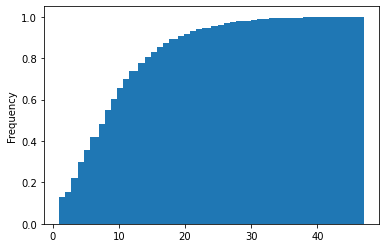

In [24]:
df_train["x_span_word_len"].plot.hist(bins=100, cumulative=True, density=True)

In [25]:
df_train.groupby("gold_raw")["x_span_word_len"].describe(percentiles=[.25,.5,.75,.90])

,count,mean,std,min,25%,50%,75%,90%,max
gold_raw,,,,,,,,,
CPR:3,777.0,10.584299,7.530242,1.0,5.0,9.0,14.0,20.0,45.0
CPR:4,2260.0,9.400442,7.070147,1.0,4.0,8.0,13.0,19.0,43.0
CPR:5,173.0,8.317919,7.442616,1.0,3.0,6.0,11.0,20.8,37.0
CPR:6,235.0,6.442553,7.202793,1.0,2.5,4.0,7.5,17.0,36.0
CPR:9,727.0,7.969739,6.667149,1.0,2.0,7.0,11.0,18.0,31.0
NEGATIVE,2265.0,9.568653,7.429337,1.0,4.0,8.0,13.0,19.6,47.0


<AxesSubplot:ylabel='Frequency'>

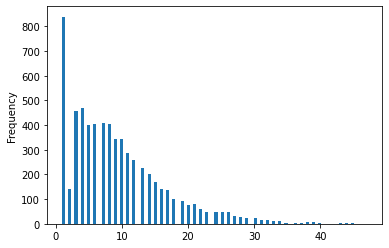

In [26]:
df_train["x_span_word_len"].plot.hist(bins=100)

In [27]:
df_train_filter = df_train\
                    .pipe(add_span_genes_chem)\
                    .pipe(filter_include_min_word_len)


train_result_filter = train_and_predict_all_classifiers(df_train_filter, min_df=1)


print_report_all_classifiers(df_train_filter["gold"],train_result_filter, labels=all_labels)

Training Naive Bayes
Max words :  331
Training Naive Bayes + Tree
Max words :  331
Extracting features..for 4131
Completed..
\begin{tabular}{llrrrr}
\toprule
             model &        index & precision & recall & f1-score & support \\
\midrule
       Naive Bayes &            0 &      65.8 &   70.3 &     68.0 &    1506 \\
       Naive Bayes &            1 &      56.9 &   62.2 &     59.4 &     555 \\
       Naive Bayes &            2 &      70.2 &   71.8 &     71.0 &    1491 \\
       Naive Bayes &            3 &      76.9 &   46.0 &     57.6 &      87 \\
       Naive Bayes &            4 &      57.0 &   57.7 &     57.3 &      78 \\
       Naive Bayes &            5 &      76.7 &   48.6 &     59.5 &     414 \\
       Naive Bayes &     accuracy &      66.8 &   66.8 &     66.8 &       0 \\
       Naive Bayes &    macro avg &      67.3 &   59.4 &     62.1 &    4131 \\
       Naive Bayes & weighted avg &      67.4 &   66.8 &     66.6 &    4131 \\
Naive Bayes + Tree &            0 &      66

,model,index,precision,recall,f1-score,support
0,Naive Bayes,0,0.658370,0.702523,0.679730,1506.000000
1,Naive Bayes,1,0.569307,0.621622,0.594315,555.000000
2,Naive Bayes,2,0.701639,0.717639,0.709549,1491.000000
3,Naive Bayes,3,0.769231,0.459770,0.575540,87.000000
4,Naive Bayes,4,0.569620,0.576923,0.573248,78.000000
5,Naive Bayes,5,0.767176,0.485507,0.594675,414.000000
accuracy,Naive Bayes,accuracy,0.667877,0.667877,0.667877,0.667877
macro avg,Naive Bayes,macro avg,0.672557,0.593997,0.621176,4131.000000
weighted avg,Naive Bayes,weighted avg,0.673585,0.667877,0.666288,4131.000000
0,Naive Bayes + Tree,0,0.665217,0.711155,0.687420,1506.000000


In [28]:
df_train = df_train.pipe(add_span_genes_chem)

In [29]:
df_train.columns

Index(['x', 'y', 'y_raw', 'abstract_id', 'abstract', 'annotations',
       'prediction', 'confidence', 'is_eval', 'relationship_type',
       'relationship_group', 'participant1_id', 'participant2_id', 'gold',
       'gold_raw', 'unique_chemprot_names', 'x_span', 'x_span_word_len'],
      dtype='object')

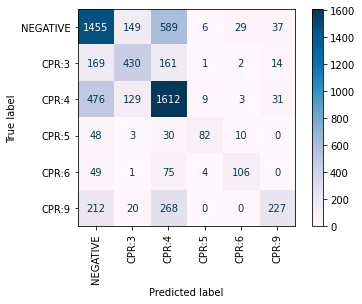

In [30]:
plot_confusionmatrix(df_train["gold"], train_result[NAIVE_BAYES]["predictions"])

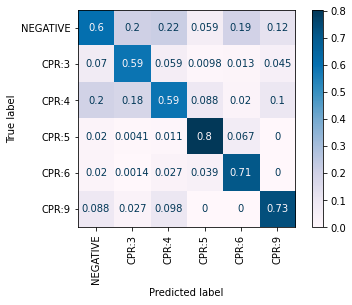

In [31]:
plot_confusionmatrix(df_train["gold"], train_result[NAIVE_BAYES]["predictions"], normalize='pred')

<AxesSubplot:ylabel='Frequency'>

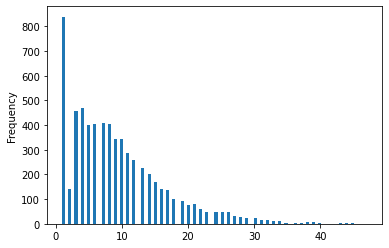

In [32]:
df_train["x_span"].apply(lambda x: len(x.split(" "))).plot.hist(bins=100)

In [33]:
df_train.query("abstract_id == 12850267")[[ "participant1_id", "participant2_id", "x_span","x", "y_raw","gold_raw","unique_chemprot_names","abstract"]]

,participant1_id,participant2_id,x_span,x,y_raw,gold_raw,unique_chemprot_names,abstract
1134,T1,T24,,"Tissue expression and translational control of GENEIG7e/CHEMIG3 transaminase K mRNAs. _CHEMICAL_ (CHEMIG10) is an endogenous CHEMIG4 receptor antagonist at the level of the different GENEIG1. One of the enzymes responsible for the production of CHEMIG10, CHEMIG11 aminotransferase I (GENEIG5), also catalyses the reversible transamination of CHEMIG3 to CHEMIG17 (GENEIG14, GENEIG13). The enzyme exists in a cytosolic and in a mitochondrial form because of the presence of two different GENEIG5 mRNAs coding for a protein respectively with and without GENEIG20 targeting the protein into mitochondria. We have cloned from a phage library of rat kidney cDNA four new GENEIG5 cDNAs containing different GENEIG6 (GENEIG16). One of the transcripts (+14GENEIG5 cDNA) contains an alternative site of initiation of translation. The tissue distribution of the different transcripts was studied by RT-PCR. The study demonstrated that several GENEIG5 mRNAs are constitutively expressed in ubiquitous manner, while +14GENEIG5 mRNA is present only in kidney. The translational efficiency of the different transcripts was studied in vitro and enzymatic activities were measured in transiently transfected Cos-1 cells. Each GENEIG5 mRNA exhibits a different in vitro translational efficiency, which corresponds to different levels of GENEIG18 enzymatic activity in transfected cells. Both findings correlate with the predicted accessibility of the ribosomal binding sites of the different mRNAs. The structure of the GENEIG19/GENEIG14 gene was also studied. The expression of several GENEIG5 mRNAs with different GENEIG9 represents an interesting example of transcriptional/translational control on the expression of CHEMIG12 (CHEMIG15)-dependent aminotransferases.",CPR:6,CPR:6,"[5' untranslated regions, 5'UTRs, EC 2.6.1.15, GTK, KA, KAT, KATI, Kynurenic acid, PLP, UTRs, glutamate, glutamate receptor, glutamine, glutamine transaminase K, ionotropic glutamate receptors, kynurenine, kynurenine aminotransferase I, leader sequence, oxoglutaramic acid, pyridoxal phosphate, pyridoxal phosphate (PLP)-dependent aminotransferases, rat KATI, rat kynurenine aminotransferas]","Tissue expression and translational control of rat kynurenine aminotransferase/glutamine transaminase K mRNAs. Kynurenic acid (KA) is an endogenous glutamate receptor antagonist at the level of the different ionotropic glutamate receptors. One of the enzymes responsible for the production of KA, kynurenine aminotransferase I (KATI), also catalyses the reversible transamination of glutamine to oxoglutaramic acid (GTK, EC 2.6.1.15). The enzyme exists in a cytosolic and in a mitochondrial form because of the presence of two different KATI mRNAs coding for a protein respectively with and without leader sequence targeting the protein into mitochondria. We have cloned from a phage library of rat kidney cDNA four new KATI cDNAs containing different 5' untranslated regions (UTRs). One of the transcripts (+14KATI cDNA) contains an alternative site of initiation of translation. The tissue distribution of the different transcripts was studied by RT-PCR. The study demonstrated that several KATI mRNAs are constitutively expressed in ubiquitous manner, while +14KATI mRNA is present only in kidney. The translational efficiency of the different transcripts was studied in vitro and enzymatic activities were measured in transiently transfected Cos-1 cells. Each KATI mRNA exhibits a different in vitro translational efficiency, which corresponds to different levels of KAT enzymatic activity in transfected cells. Both findings correlate with the predicted accessibility of the ribosomal binding sites of the different mRNAs. The structure of the rat KATI/GTK gene was also studied. The expression of several KATI mRNAs with different 5'UTRs represents an interesting example of transcriptional/translational control on the expression of

In [34]:
df_train.groupby(["abstract_id"])["gold_raw"].unique().apply(frozenset).value_counts()

(NEGATIVE)                                132
(CPR:4)                                   117
(NEGATIVE, CPR:4)                         103
(NEGATIVE, CPR:4, CPR:3)                   65
(NEGATIVE, CPR:3)                          44
(CPR:9)                                    34
(NEGATIVE, CPR:9)                          33
(CPR:4, CPR:3)                             31
(CPR:3)                                    27
(CPR:4, CPR:9)                             27
(NEGATIVE, CPR:4, CPR:9)                   24
(CPR:6)                                    15
(NEGATIVE, CPR:6)                          15
(CPR:5)                                    10
(NEGATIVE, CPR:5)                          10
(CPR:9, NEGATIVE, CPR:4, CPR:3)             8
(CPR:9, NEGATIVE, CPR:3)                    7
(CPR:4, CPR:6)                              7
(NEGATIVE, CPR:5, CPR:6)                    7
(NEGATIVE, CPR:4, CPR:6)                    6
(NEGATIVE, CPR:3, CPR:5, CPR:6, CPR:4)      6
(CPR:5, CPR:6)                    

<AxesSubplot:ylabel='Frequency'>

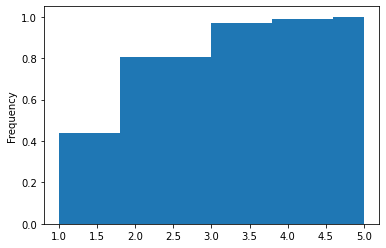

In [35]:
df_train.groupby(["abstract_id"])["gold_raw"].nunique().plot.hist(cumulative=True, density=True)

<AxesSubplot:ylabel='Frequency'>

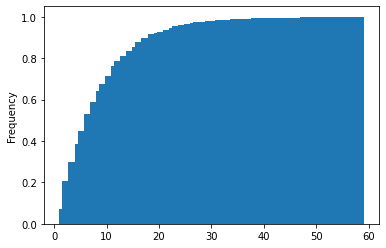

In [36]:
df_train.groupby(["abstract_id"]).size().plot.hist(bins=100, cumulative=True, density=True)

<AxesSubplot:ylabel='Frequency'>

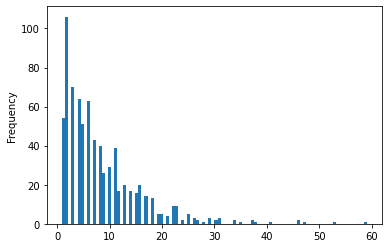

In [37]:
df_train.groupby(["abstract_id"]).size().plot.hist(bins=100)

In [38]:
df_train["abstract_id"].nunique() , 767, 6437

(767, 767, 6437)

In [39]:
df_train["abstract_id"].shape

(6437,)

In [40]:
if TREE in train_result:
    plot_tree(train_result[TREE]["m"])


In [41]:
get_top_discrimintary_keywords(train_result[NAIVE_BAYES]["m"],1)[:50]

[('_gene_', -1.8386792081367762),
 ('_chemical_', -1.8386792081367762),
 ('increased', -3.561175206498607),
 ('expression', -3.690386937978613),
 ('induced', -3.6990450007217275),
 ('increase', -4.087268302395386),
 ('activity', -4.333103264911666),
 ('activation', -4.4366439438525065),
 ('significantly', -4.5121514963606515),
 ('geneig4', -4.659787495166716),
 ('geneig5', -4.682777013391416),
 ('geneig2', -4.73040506238067),
 ('geneig9', -4.755097674971042),
 ('geneig3', -4.755097674971042),
 ('cells', -4.755097674971042),
 ('geneig10', -4.780415482955331),
 ('geneig1', -4.833059216440754),
 ('phosphorylation', -4.833059216440754),
 ('geneig6', -4.860458190628868),
 ('geneig0', -4.860458190628868),
 ('induction', -4.860458190628868),
 ('treatment', -4.860458190628868),
 ('apoptosis', -4.888629067595565),
 ('geneig7', -4.917616604468816),
 ('geneig8', -4.947469567618498),
 ('protein', -4.978241226285251),
 ('geneig13', -5.042779747422822),
 ('chemig0', -5.076681299098503),
 ('caused', 

In [42]:
sklearn.metrics.cohen_kappa_score(df_train["gold"],
                                  train_result[NAIVE_BAYES]["predictions"]
                                  )

0.43859198697282853

In [43]:
sklearn.metrics.cohen_kappa_score(df_train["gold"],
                                  train_result[NAIVE_BAYES_WITH_TREE]["predictions"]
                                  )

0.43251068454890507

## Val GT predictions


In [44]:
df_val = load_valtest_pred(local_val_prediction_file)


val_result = train_and_predict_all_classifiers(df_val, min_df=1)




print_report_all_classifiers(df_val["gold"],val_result, labels=pos_labels)

Training Naive Bayes
Max words :  327
Training Naive Bayes + Tree
Max words :  327
Extracting features..for 3558
Completed..
\begin{tabular}{llrrrr}
\toprule
             model &        index & precision & recall & f1-score & support \\
\midrule
       Naive Bayes &            1 &      59.3 &   55.4 &     57.3 &     552 \\
       Naive Bayes &            2 &      59.0 &   76.2 &     66.5 &    1103 \\
       Naive Bayes &            3 &      73.3 &   63.8 &     68.2 &     116 \\
       Naive Bayes &            4 &      82.5 &   56.8 &     67.3 &     199 \\
       Naive Bayes &            5 &      78.2 &   46.4 &     58.2 &     457 \\
       Naive Bayes &    micro avg &      63.1 &   63.7 &     63.4 &    2427 \\
       Naive Bayes &    macro avg &      70.5 &   59.7 &     63.5 &    2427 \\
       Naive Bayes & weighted avg &      65.3 &   63.7 &     63.0 &    2427 \\
Naive Bayes + Tree &            1 &      56.7 &   58.9 &     57.8 &     552 \\
Naive Bayes + Tree &            2 &      58

,model,index,precision,recall,f1-score,support
1,Naive Bayes,1,0.593023,0.554348,0.573034,552.0
2,Naive Bayes,2,0.589888,0.761559,0.664820,1103.0
3,Naive Bayes,3,0.732673,0.637931,0.682028,116.0
4,Naive Bayes,4,0.824818,0.567839,0.672619,199.0
5,Naive Bayes,5,0.782288,0.463895,0.582418,457.0
micro avg,Naive Bayes,micro avg,0.630870,0.636588,0.633716,2427.0
macro avg,Naive Bayes,macro avg,0.704538,0.597114,0.634984,2427.0
weighted avg,Naive Bayes,weighted avg,0.652917,0.636588,0.629890,2427.0
1,Naive Bayes + Tree,1,0.567190,0.588768,0.577778,552.0
2,Naive Bayes + Tree,2,0.589385,0.765186,0.665878,1103.0


In [45]:
df_val_prediction = load_valtest_pred(local_val_prediction_file)

val_prediction_result = train_and_predict_all_classifiers(df_val_prediction, min_df=1)




print_report_all_classifiers(df_val_prediction["y"], val_prediction_result, all_labels)

Training Naive Bayes
Max words :  327
Training Naive Bayes + Tree
Max words :  327
Extracting features..for 3558
Completed..
\begin{tabular}{llrrrr}
\toprule
             model &        index & precision & recall & f1-score & support \\
\midrule
       Naive Bayes &            0 &      63.0 &   67.5 &     65.2 &    1036 \\
       Naive Bayes &            1 &      71.1 &   59.2 &     64.6 &     620 \\
       Naive Bayes &            2 &      61.3 &   77.3 &     68.4 &    1129 \\
       Naive Bayes &            3 &      81.2 &   64.1 &     71.6 &     128 \\
       Naive Bayes &            4 &      83.9 &   58.7 &     69.1 &     196 \\
       Naive Bayes &            5 &      84.9 &   51.2 &     63.9 &     449 \\
       Naive Bayes &     accuracy &      66.5 &   66.5 &     66.5 &       0 \\
       Naive Bayes &    macro avg &      74.2 &   63.0 &     67.1 &    3558 \\
       Naive Bayes & weighted avg &      68.5 &   66.5 &     66.4 &    3558 \\
Naive Bayes + Tree &            0 &      65

,model,index,precision,recall,f1-score,support
0,Naive Bayes,0,0.630298,0.674710,0.651748,1036.000000
1,Naive Bayes,1,0.711240,0.591935,0.646127,620.000000
2,Naive Bayes,2,0.613062,0.773251,0.683901,1129.000000
3,Naive Bayes,3,0.811881,0.640625,0.716157,128.000000
4,Naive Bayes,4,0.839416,0.586735,0.690691,196.000000
5,Naive Bayes,5,0.848708,0.512249,0.638889,449.000000
accuracy,Naive Bayes,accuracy,0.664980,0.664980,0.664980,0.664980
macro avg,Naive Bayes,macro avg,0.742434,0.629918,0.671252,3558.000000
weighted avg,Naive Bayes,weighted avg,0.684548,0.664980,0.663811,3558.000000
0,Naive Bayes + Tree,0,0.656190,0.665058,0.660594,1036.000000


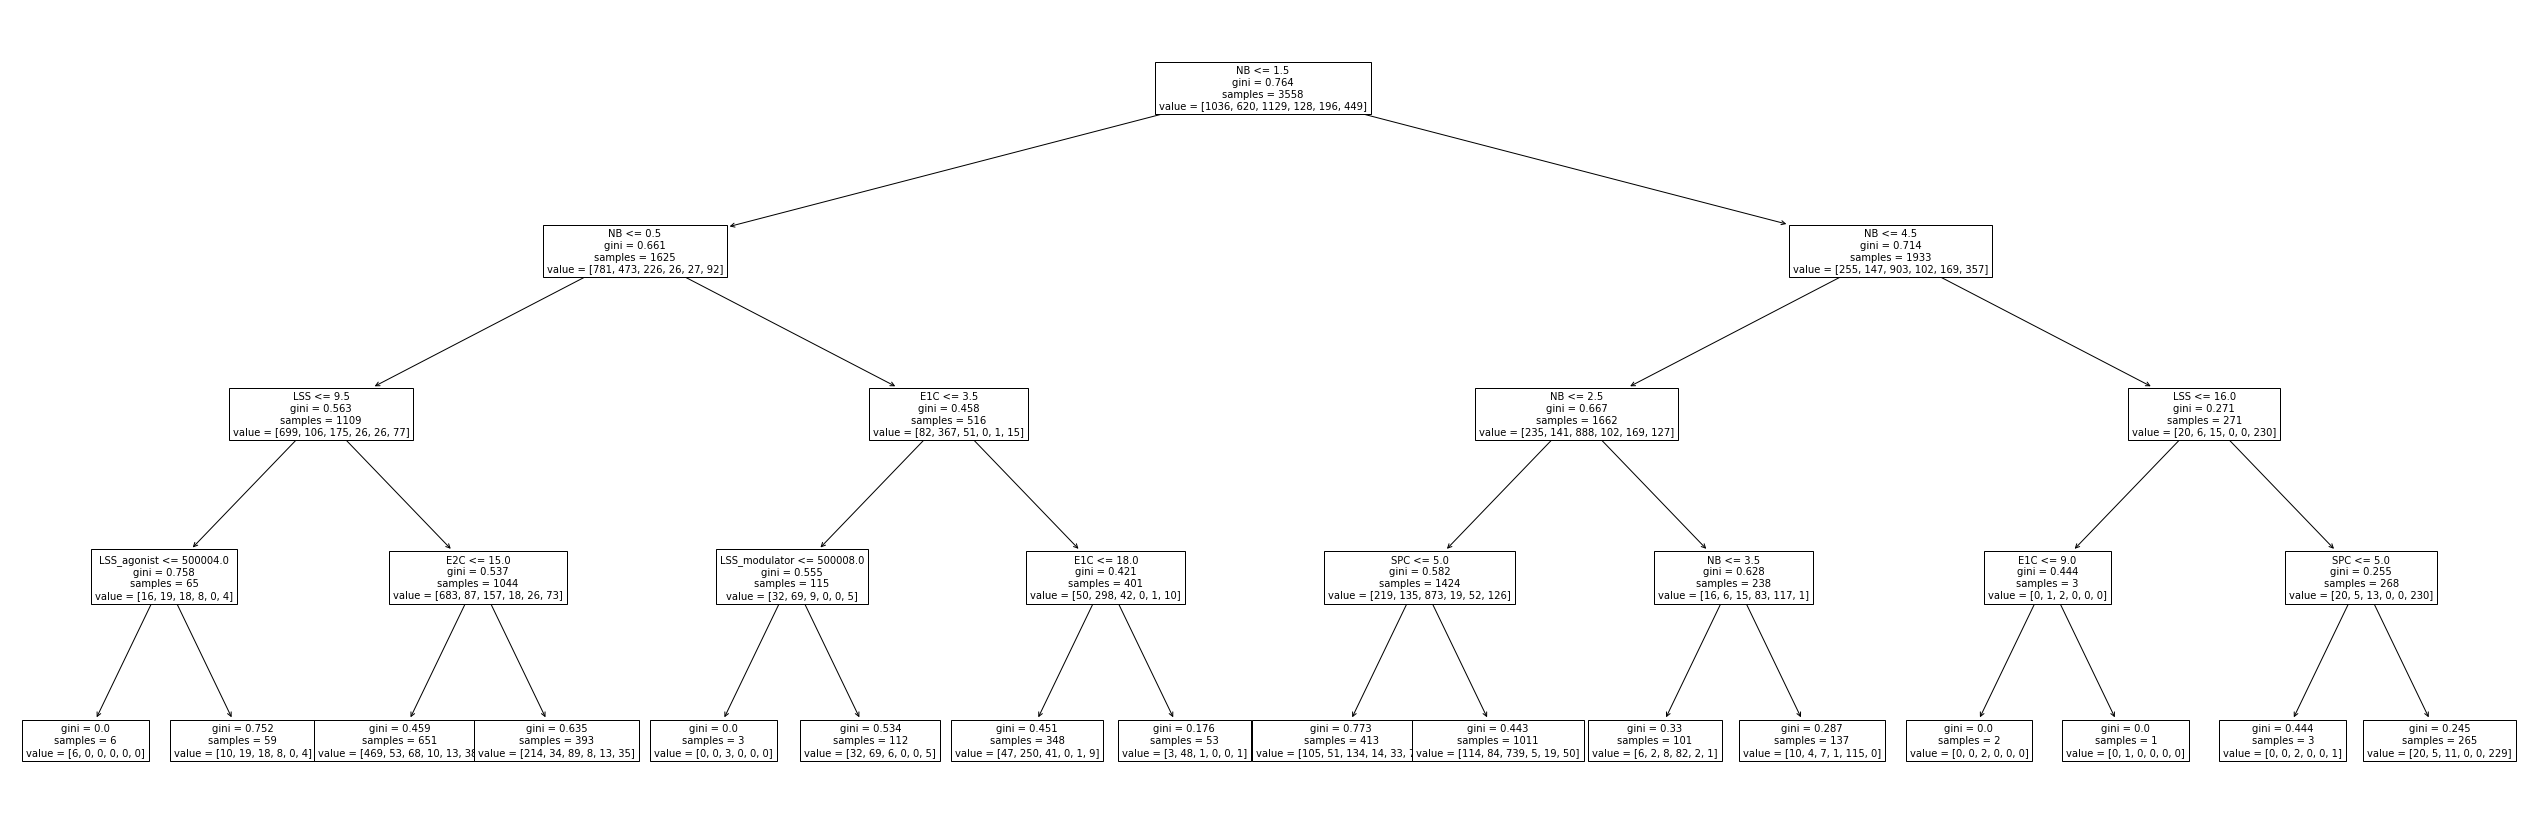

In [46]:
if NAIVE_BAYES_WITH_TREE in val_prediction_result: 
    plot_tree(val_prediction_result[NAIVE_BAYES_WITH_TREE]["m"])

## Test 

In [47]:
df_test = load_valtest_pred(local_test_prediction_file)


print_report_original(df_test, "y_raw", test_gold_file )


Running command
java -cp ../thirdparty/bc6chemprot_eval.jar org.biocreative.tasks.chemprot.main.Main -TP TRUE -FP TRUE -FN TRUE /var/folders/7v/5_mr86mx7l9g94fxzdpdx0nw0000gn/T/tmpc05ow398 temp/prediction/chemprot_test_gold_standard.tsv

The file:
	./out/eval.txt
was successfully created.

The file:
	./out/tp.txt
was successfully created.

The file:
	./out/fp.txt
was successfully created.

The file:
	./out/fn.txt
was successfully created.

['\n', 'Total annotations: 3458\n', 'Total predictions: 3726\n', 'TP: 2853\n', 'FN: 605\n', 'FP: 873\n', 'Precision: 0.7657004830917874\n', 'Recall: 0.8250433776749566\n', 'F-score: 0.7942650334075724']


c,FN,FP,TP,P,R,F
y,,,,,,
CPR:3,152.0,245.0,513.0,0.676781,0.771429,0.721012
CPR:4,262.0,306.0,1399.0,0.820528,0.842264,0.831254
CPR:5,37.0,30.0,158.0,0.840426,0.810256,0.825065
CPR:6,48.0,49.0,245.0,0.833333,0.836177,0.834753
CPR:9,106.0,196.0,538.0,0.732970,0.835404,0.780842
total,605.0,826.0,2853.0,0.775482,0.825043,0.799496


In [48]:
l = 'CPR:3'
tp = df_test.query(f"y_raw=='{l}' and gold_raw=='{l}'").shape[0]
fp = df_test.query(f"y_raw=='{l}' and gold_raw!='{l}'").shape[0]
fn = df_test.query(f"y_raw!='{l}' and gold_raw=='{l}'").shape[0]


fn, fp, tp

(152, 256, 515)

In [49]:
df_test = load_valtest_pred(local_test_prediction_file)

print_report(df_test["gold"],df_test["y"], labels=pos_labels)

,precision,recall,f1-score,support
1,0.667964,0.772114,0.716273,667.0
2,0.814493,0.842831,0.828420,1667.0
3,0.811224,0.803030,0.807107,198.0
4,0.816667,0.836177,0.826307,293.0
5,0.732970,0.835404,0.780842,644.0
micro avg,0.768116,0.825022,0.795552,3469.0
macro avg,0.768664,0.817911,0.791790,3469.0
weighted avg,0.771182,0.825022,0.796629,3469.0


In [50]:
print_report(df_test["gold"],df_test["y"], labels=all_labels)

,precision,recall,f1-score,support
0,0.820614,0.727912,0.771488,2275.00000
1,0.667964,0.772114,0.716273,667.00000
2,0.814493,0.842831,0.828420,1667.00000
3,0.811224,0.803030,0.807107,198.00000
4,0.816667,0.836177,0.826307,293.00000
5,0.732970,0.835404,0.780842,644.00000
accuracy,0.786560,0.786560,0.786560,0.78656
macro avg,0.777322,0.802911,0.788406,5744.00000
weighted avg,0.790760,0.786560,0.786672,5744.00000


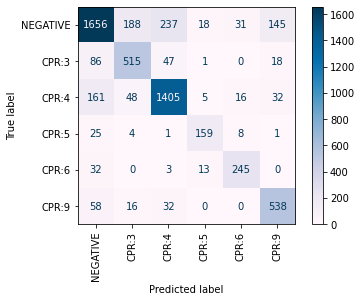

In [51]:
plot_confusionmatrix(df_test["gold"],df_test["y"] )

In [52]:
df_test["abstract_id"].shape, df_test["abstract_id"].nunique()

((5744,), 620)

### Predict Test on Test GT fit

In [53]:
df_test = load_valtest_pred(local_test_prediction_file)


result_test_gt = train_and_predict_all_classifiers(df_test, min_df=1)



print_report_all_classifiers(df_test["gold"], result_test_gt, labels=pos_labels)



Training Naive Bayes
Max words :  315
Training Naive Bayes + Tree
Max words :  315
Extracting features..for 5744
Completed..
\begin{tabular}{llrrrr}
\toprule
             model &        index & precision & recall & f1-score & support \\
\midrule
       Naive Bayes &            1 &      51.9 &   51.4 &     51.7 &     667 \\
       Naive Bayes &            2 &      70.7 &   56.9 &     63.1 &    1667 \\
       Naive Bayes &            3 &      63.7 &   43.4 &     51.7 &     198 \\
       Naive Bayes &            4 &      63.7 &   42.0 &     50.6 &     293 \\
       Naive Bayes &            5 &      61.1 &   32.9 &     42.8 &     644 \\
       Naive Bayes &    micro avg &      64.0 &   49.4 &     55.7 &    3469 \\
       Naive Bayes &    macro avg &      62.2 &   45.3 &     52.0 &    3469 \\
       Naive Bayes & weighted avg &      64.3 &   49.4 &     55.4 &    3469 \\
Naive Bayes + Tree &            1 &      52.8 &   51.4 &     52.1 &     667 \\
Naive Bayes + Tree &            2 &      71

,model,index,precision,recall,f1-score,support
1,Naive Bayes,1,0.518911,0.514243,0.516566,667.0
2,Naive Bayes,2,0.707154,0.569286,0.630774,1667.0
3,Naive Bayes,3,0.637037,0.434343,0.516517,198.0
4,Naive Bayes,4,0.637306,0.419795,0.506173,293.0
5,Naive Bayes,5,0.610951,0.329193,0.427851,644.0
micro avg,Naive Bayes,micro avg,0.639656,0.493802,0.557345,3469.0
macro avg,Naive Bayes,macro avg,0.622272,0.453372,0.519576,3469.0
weighted avg,Naive Bayes,weighted avg,0.643198,0.493802,0.554098,3469.0
1,Naive Bayes + Tree,1,0.527692,0.514243,0.520881,667.0
2,Naive Bayes + Tree,2,0.710112,0.568686,0.631579,1667.0


In [54]:
result_train_predict_test_gt = predict_all_classifiers(df_test, train_result)

print_report_all_classifiers(df_test["gold"], result_train_predict_test_gt,  all_labels)





\begin{tabular}{llrrrr}
\toprule
             model &        index & precision & recall & f1-score & support \\
\midrule
       Naive Bayes &            0 &      57.9 &   55.2 &     56.5 &    2275 \\
       Naive Bayes &            1 &      48.3 &   41.7 &     44.7 &     667 \\
       Naive Bayes &            2 &      45.2 &   67.1 &     54.0 &    1667 \\
       Naive Bayes &            3 &      65.8 &   24.2 &     35.4 &     198 \\
       Naive Bayes &            4 &      59.3 &   27.3 &     37.4 &     293 \\
       Naive Bayes &            5 &      53.5 &   26.1 &     35.1 &     644 \\
       Naive Bayes &     accuracy &      51.3 &   51.3 &     51.3 &       0 \\
       Naive Bayes &    macro avg &      55.0 &   40.3 &     43.8 &    5744 \\
       Naive Bayes & weighted avg &      52.9 &   51.3 &     50.3 &    5744 \\
Naive Bayes + Tree &            0 &      53.5 &   69.8 &     60.6 &    2275 \\
Naive Bayes + Tree &            1 &      48.8 &   44.7 &     46.6 &     667 \\
Naive Baye

,model,index,precision,recall,f1-score,support
0,Naive Bayes,0,0.578608,0.551648,0.564806,2275.000000
1,Naive Bayes,1,0.482639,0.416792,0.447305,667.000000
2,Naive Bayes,2,0.451756,0.671266,0.540058,1667.000000
3,Naive Bayes,3,0.657534,0.242424,0.354244,198.000000
4,Naive Bayes,4,0.592593,0.273038,0.373832,293.000000
5,Naive Bayes,5,0.535032,0.260870,0.350731,644.000000
accuracy,Naive Bayes,accuracy,0.513231,0.513231,0.513231,0.513231
macro avg,Naive Bayes,macro avg,0.549694,0.402673,0.438496,5744.000000
weighted avg,Naive Bayes,weighted avg,0.529198,0.513231,0.502978,5744.000000
0,Naive Bayes + Tree,0,0.534657,0.698462,0.605679,2275.000000


In [55]:
result_train_predict_test_gt = predict_all_classifiers(df_test, train_result)

print_report_all_classifiers(df_test["y"], result_train_predict_test_gt,  all_labels)



\begin{tabular}{llrrrr}
\toprule
             model &        index & precision & recall & f1-score & support \\
\midrule
       Naive Bayes &            0 &      55.7 &   59.9 &     57.7 &    2018 \\
       Naive Bayes &            1 &      53.1 &   39.7 &     45.4 &     771 \\
       Naive Bayes &            2 &      47.2 &   67.8 &     55.7 &    1725 \\
       Naive Bayes &            3 &      71.2 &   26.5 &     38.7 &     196 \\
       Naive Bayes &            4 &      60.7 &   27.3 &     37.7 &     300 \\
       Naive Bayes &            5 &      64.6 &   27.7 &     38.7 &     734 \\
       Naive Bayes &     accuracy &      52.6 &   52.6 &     52.6 &       0 \\
       Naive Bayes &    macro avg &      58.8 &   41.5 &     45.7 &    5744 \\
       Naive Bayes & weighted avg &      54.7 &   52.6 &     51.3 &    5744 \\
Naive Bayes + Tree &            0 &      49.7 &   73.2 &     59.2 &    2018 \\
Naive Bayes + Tree &            1 &      53.5 &   42.4 &     47.3 &     771 \\
Naive Baye

,model,index,precision,recall,f1-score,support
0,Naive Bayes,0,0.556939,0.598612,0.577024,2018.000000
1,Naive Bayes,1,0.531250,0.396887,0.454343,771.000000
2,Naive Bayes,2,0.472346,0.678261,0.556878,1725.000000
3,Naive Bayes,3,0.712329,0.265306,0.386617,196.000000
4,Naive Bayes,4,0.607407,0.273333,0.377011,300.000000
5,Naive Bayes,5,0.646497,0.276567,0.387405,734.000000
accuracy,Naive Bayes,accuracy,0.525940,0.525940,0.525940,0.525940
macro avg,Naive Bayes,macro avg,0.587795,0.414828,0.456546,5744.000000
weighted avg,Naive Bayes,weighted avg,0.547469,0.525940,0.513333,5744.000000
0,Naive Bayes + Tree,0,0.496972,0.731913,0.591984,2018.000000


In [56]:
df_test_filter = df_test\
                    .pipe(add_span_genes_chem)\
                    .pipe(filter_include_min_word_len)


result_train_filter_predict_test_filter_gt = predict_all_classifiers(df_test_filter, train_result_filter)

print_report_all_classifiers(df_test_filter["y"], result_train_filter_predict_test_filter_gt,  all_labels)






\begin{tabular}{llrrrr}
\toprule
             model &        index & precision & recall & f1-score & support \\
\midrule
       Naive Bayes &            0 &      56.9 &   64.3 &     60.4 &    1395 \\
       Naive Bayes &            1 &      47.5 &   44.8 &     46.1 &     502 \\
       Naive Bayes &            2 &      58.2 &   65.4 &     61.6 &    1182 \\
       Naive Bayes &            3 &      56.7 &   17.7 &     27.0 &      96 \\
       Naive Bayes &            4 &      30.0 &    9.0 &     13.8 &     100 \\
       Naive Bayes &            5 &      64.5 &   38.5 &     48.2 &     410 \\
       Naive Bayes &     accuracy &      56.4 &   56.4 &     56.4 &       0 \\
       Naive Bayes &    macro avg &      52.3 &   40.0 &     42.9 &    3685 \\
       Naive Bayes & weighted avg &      56.1 &   56.4 &     55.3 &    3685 \\
Naive Bayes + Tree &            0 &      57.1 &   64.8 &     60.7 &    1395 \\
Naive Bayes + Tree &            1 &      47.6 &   44.6 &     46.0 &     502 \\
Naive Baye

,model,index,precision,recall,f1-score,support
0,Naive Bayes,0,0.568802,0.643011,0.603634,1395.000000
1,Naive Bayes,1,0.474684,0.448207,0.461066,502.000000
2,Naive Bayes,2,0.581640,0.653976,0.615691,1182.000000
3,Naive Bayes,3,0.566667,0.177083,0.269841,96.000000
4,Naive Bayes,4,0.300000,0.090000,0.138462,100.000000
5,Naive Bayes,5,0.644898,0.385366,0.482443,410.000000
accuracy,Naive Bayes,accuracy,0.564179,0.564179,0.564179,0.564179
macro avg,Naive Bayes,macro avg,0.522782,0.399607,0.428523,3685.000000
weighted avg,Naive Bayes,weighted avg,0.561215,0.564179,0.553276,3685.000000
0,Naive Bayes + Tree,0,0.570707,0.648029,0.606915,1395.000000


In [57]:

result_train_filter_predict_test_gt = predict_all_classifiers(df_test, train_result_filter)

print_report_all_classifiers(df_test["y"], result_train_filter_predict_test_gt,  all_labels)





\begin{tabular}{llrrrr}
\toprule
             model &        index & precision & recall & f1-score & support \\
\midrule
       Naive Bayes &            0 &      51.8 &   60.2 &     55.7 &    2018 \\
       Naive Bayes &            1 &      51.1 &   34.6 &     41.3 &     771 \\
       Naive Bayes &            2 &      46.1 &   67.5 &     54.8 &    1725 \\
       Naive Bayes &            3 &      60.5 &   11.7 &     19.7 &     196 \\
       Naive Bayes &            4 &      43.6 &    5.7 &     10.0 &     300 \\
       Naive Bayes &            5 &      64.7 &   24.5 &     35.6 &     734 \\
       Naive Bayes &     accuracy &      49.9 &   49.9 &     49.9 &       0 \\
       Naive Bayes &    macro avg &      53.0 &   34.0 &     36.2 &    5744 \\
       Naive Bayes & weighted avg &      51.5 &   49.9 &     47.3 &    5744 \\
Naive Bayes + Tree &            0 &      52.0 &   60.5 &     55.9 &    2018 \\
Naive Bayes + Tree &            1 &      51.3 &   34.5 &     41.2 &     771 \\
Naive Baye

,model,index,precision,recall,f1-score,support
0,Naive Bayes,0,0.518139,0.601586,0.556753,2018.000000
1,Naive Bayes,1,0.511494,0.346304,0.412993,771.000000
2,Naive Bayes,2,0.461173,0.674783,0.547894,1725.000000
3,Naive Bayes,3,0.605263,0.117347,0.196581,196.000000
4,Naive Bayes,4,0.435897,0.056667,0.100295,300.000000
5,Naive Bayes,5,0.647482,0.245232,0.355731,734.000000
accuracy,Naive Bayes,accuracy,0.498781,0.498781,0.498781,0.498781
macro avg,Naive Bayes,macro avg,0.529908,0.340320,0.361708,5744.000000
weighted avg,Naive Bayes,weighted avg,0.515345,0.498781,0.472978,5744.000000
0,Naive Bayes + Tree,0,0.519591,0.604559,0.558864,2018.000000


In [58]:
sklearn.metrics.cohen_kappa_score(df_test["gold"],
                                  result_test_gt[NAIVE_BAYES]["predictions"]
                                  )

0.4202044852836534

In [59]:
sklearn.metrics.cohen_kappa_score(df_test["gold"],
                                  result_test_gt[NAIVE_BAYES_WITH_TREE]["predictions"]
                                  )

0.42339577433977704

### Predict Test on Test Prediction fit 

In [60]:
df_test_prediction = load_valtest_pred(local_test_prediction_file)

result_test_bp = train_and_predict_all_classifiers(df_test_prediction, min_df=1)

#plot_tree(result_test_bp[NAIVE_BAYES_WITH_TREE]["m"])


print_report_all_classifiers(df_test_prediction["y"], result_test_bp,  pos_labels)

print_report_all_classifiers(df_test_prediction["y"], result_test_bp,  all_labels)




Training Naive Bayes
Max words :  315
Training Naive Bayes + Tree
Max words :  315
Extracting features..for 5744
Completed..
\begin{tabular}{llrrrr}
\toprule
             model &        index & precision & recall & f1-score & support \\
\midrule
       Naive Bayes &            1 &      65.5 &   56.2 &     60.5 &     771 \\
       Naive Bayes &            2 &      78.2 &   60.8 &     68.4 &    1725 \\
       Naive Bayes &            3 &      77.8 &   53.6 &     63.4 &     196 \\
       Naive Bayes &            4 &      71.5 &   46.0 &     56.0 &     300 \\
       Naive Bayes &            5 &      79.3 &   37.5 &     50.9 &     734 \\
       Naive Bayes &    micro avg &      74.7 &   53.7 &     62.5 &    3726 \\
       Naive Bayes &    macro avg &      74.4 &   50.8 &     59.8 &    3726 \\
       Naive Bayes & weighted avg &      75.2 &   53.7 &     62.1 &    3726 \\
Naive Bayes + Tree &            1 &      66.6 &   56.2 &     60.9 &     771 \\
Naive Bayes + Tree &            2 &      78

,model,index,precision,recall,f1-score,support
0,Naive Bayes,0,0.553490,0.840932,0.667585,2018.000000
1,Naive Bayes,1,0.655068,0.561608,0.604749,771.000000
2,Naive Bayes,2,0.781669,0.608116,0.684056,1725.000000
3,Naive Bayes,3,0.777778,0.535714,0.634441,196.000000
4,Naive Bayes,4,0.715026,0.460000,0.559838,300.000000
5,Naive Bayes,5,0.792507,0.374659,0.508788,734.000000
accuracy,Naive Bayes,accuracy,0.643628,0.643628,0.643628,0.643628
macro avg,Naive Bayes,macro avg,0.712590,0.563505,0.609909,5744.000000
weighted avg,Naive Bayes,weighted avg,0.682283,0.643628,0.637047,5744.000000
0,Naive Bayes + Tree,0,0.555772,0.849356,0.671893,2018.000000


In [61]:
p1 = get_top_discrimintary_keywords(result_test_bp[NAIVE_BAYES]["m"],0)
p2 = get_top_discrimintary_keywords(train_result[NAIVE_BAYES]["m"],0)

kl_divergence(p1,p2)

0.07715738936992479

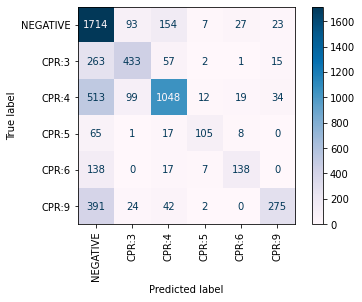

In [62]:
if NAIVE_BAYES_WITH_TREE in result_test_bp:
    df_test_prediction["shortcut_pred_nbt"] = result_test_bp[NAIVE_BAYES_WITH_TREE]["predictions"]
    print_report(df_test_prediction.query("y == gold")["y"], df_test_prediction.query("y == gold")["shortcut_pred_nbt"], all_labels)
    plot_confusionmatrix(df_test_prediction["y"], df_test_prediction["shortcut_pred_nbt"])

In [63]:
sklearn.metrics.cohen_kappa_score(df_test_prediction["y"],
                                  result_test_gt[NAIVE_BAYES_WITH_TREE]["predictions"]
                                  )

0.5062389159900134

In [64]:
sklearn.metrics.cohen_kappa_score(df_test_prediction["y"],
                                  result_test_gt[NAIVE_BAYES]["predictions"]
                                  )

0.5026810167988787

## Test BP 

In [65]:
result_train_predict_test_bp = predict_all_classifiers(df_test_prediction, train_result)

print_report_all_classifiers(df_test_prediction["y"], result_train_predict_test_bp,  all_labels)





\begin{tabular}{llrrrr}
\toprule
             model &        index & precision & recall & f1-score & support \\
\midrule
       Naive Bayes &            0 &      55.7 &   59.9 &     57.7 &    2018 \\
       Naive Bayes &            1 &      53.1 &   39.7 &     45.4 &     771 \\
       Naive Bayes &            2 &      47.2 &   67.8 &     55.7 &    1725 \\
       Naive Bayes &            3 &      71.2 &   26.5 &     38.7 &     196 \\
       Naive Bayes &            4 &      60.7 &   27.3 &     37.7 &     300 \\
       Naive Bayes &            5 &      64.6 &   27.7 &     38.7 &     734 \\
       Naive Bayes &     accuracy &      52.6 &   52.6 &     52.6 &       0 \\
       Naive Bayes &    macro avg &      58.8 &   41.5 &     45.7 &    5744 \\
       Naive Bayes & weighted avg &      54.7 &   52.6 &     51.3 &    5744 \\
Naive Bayes + Tree &            0 &      49.7 &   73.2 &     59.2 &    2018 \\
Naive Bayes + Tree &            1 &      53.5 &   42.4 &     47.3 &     771 \\
Naive Baye

,model,index,precision,recall,f1-score,support
0,Naive Bayes,0,0.556939,0.598612,0.577024,2018.000000
1,Naive Bayes,1,0.531250,0.396887,0.454343,771.000000
2,Naive Bayes,2,0.472346,0.678261,0.556878,1725.000000
3,Naive Bayes,3,0.712329,0.265306,0.386617,196.000000
4,Naive Bayes,4,0.607407,0.273333,0.377011,300.000000
5,Naive Bayes,5,0.646497,0.276567,0.387405,734.000000
accuracy,Naive Bayes,accuracy,0.525940,0.525940,0.525940,0.525940
macro avg,Naive Bayes,macro avg,0.587795,0.414828,0.456546,5744.000000
weighted avg,Naive Bayes,weighted avg,0.547469,0.525940,0.513333,5744.000000
0,Naive Bayes + Tree,0,0.496972,0.731913,0.591984,2018.000000


## Large scale high quality

In [66]:
df_highquality = load_valtest_pred(local_highquality_file)\
                .pipe(add_span_genes_chem)\
               # .pipe(filter_include_max_word_len, 19)

In [67]:
result_highquality_bp = train_and_predict_all_classifiers(df_highquality, min_df=1)
print_report_all_classifiers(df_highquality["y"], result_highquality_bp,  all_labels)


df_highquality["nb_predictions"]=result_highquality_bp[NAIVE_BAYES]["predictions"]

Training Naive Bayes
Max words :  264
Training Naive Bayes + Tree
Max words :  264
Extracting features..for 40120
Completed..
\begin{tabular}{llrrrr}
\toprule
             model &        index & precision & recall & f1-score & support \\
\midrule
       Naive Bayes &            0 &      53.8 &   51.9 &     52.9 &   10000 \\
       Naive Bayes &            1 &      54.9 &   56.5 &     55.7 &    9456 \\
       Naive Bayes &            2 &      58.8 &   54.2 &     56.4 &    9999 \\
       Naive Bayes &            3 &      26.1 &   85.7 &     40.0 &       7 \\
       Naive Bayes &            4 &      39.3 &   75.2 &     51.7 &     856 \\
       Naive Bayes &            5 &      62.9 &   63.4 &     63.1 &    9802 \\
       Naive Bayes &     accuracy &      56.9 &   56.9 &     56.9 &       0 \\
       Naive Bayes &    macro avg &      49.3 &   64.5 &     53.3 &   40120 \\
       Naive Bayes & weighted avg &      57.2 &   56.9 &     56.9 &   40120 \\
Naive Bayes + Tree &            0 &      5

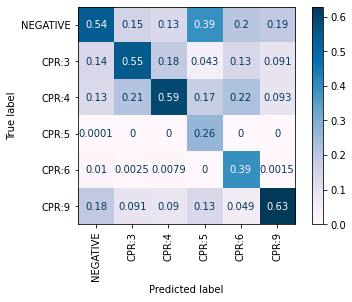

In [68]:
plot_confusionmatrix(df_highquality["y"],df_highquality["nb_predictions"], "pred")

In [69]:
df_highquality.columns

Index(['x', 'y', 'y_raw', 'abstract_id', 'abstract', 'participant1_id',
       'participant1', 'participant2_id', 'participant2', 'annotations',
       'relationship_type', 'relationship_group', 'is_eval', 'label',
       'NEGATIVE', 'CPR:3', 'CPR:4', 'CPR:5', 'CPR:6', 'CPR:9', 'prediction',
       'confidence', 'confidence_std', 'raw_confidence',
       'RecordInTrainingData', 'gold', 'gold_raw', 'x_span', 'x_span_word_len',
       'nb_predictions'],
      dtype='object')

In [70]:
df_highquality.y_raw.value_counts()

NEGATIVE    10000
CPR:4        9999
CPR:9        9802
CPR:3        9456
CPR:6         856
CPR:5           7
Name: y_raw, dtype: int64

In [71]:
df_highquality.query("x_span_word_len < 15").sample(n=5)[["x","y_raw","y","nb_predictions"]]

,x,y_raw,y,nb_predictions
3788,"Malaria parasites adapt to the oxidative stress during their erythrocytic stages with the help of vital _GENE_ redox system and _CHEMICAL_ redox system. GENEIG0 and GENEIG1 are important enzymes of these redox systems that help parasites to maintain an adequate intracellular redox environment. In the present study, activities of GENEIG2 and GENEIG1 were investigated in normal and Plasmodium berghei-infected mice red blood cells and their fractions. Activities of GENEIG2 and GENEIG1 in P. berghei-infected host erythrocytes were found to be higher than those in normal host cells. These enzymes were mainly confined to the cytosolic part of cell-free P. berghei. Full characterization and understanding of these enzymes may promise advances in chemotherapy of malaria.",CPR:9,5,0
38007,"The production of the heavy metal-binding proteins, the GENEIG16 (MTs), is induced by heavy metals such as Zn, CHEMIG8 and Hg. GENEIG6 maintain CHEMIG4 homeostasis and attenuate heavy metal-induced cytotoxicity by sequestering these metals and lowering their intracellular concentrations. Previously, we had reported that CHEMIG4 induced the formation of a co-activator complex containing GENEIG1 and the GENEIG7 which plays an essential role in the activation of _GENE_ transcription. In addition, we had shown that _CHEMICAL_ inhibits Zn-induced GENEIG12 transcription by preventing the Zn-dependent formation of the GENEIG14 complex. In the current study, we have shown that the inhibition by Cr(VI) was partially overcome by the overexpression of GENEIG5 or GENEIG2 in an MT-I promoter-driven luciferase reporter assay system and have used real-time RT-PCR to determine GENEIG13 mRNA levels. It has been reported that CHEMIG9 inhibits GENEIG15 transcription by crosslinking GENEIG0 to the promoter. The crosslink inhibits the recruitment of GENEIG5 to the GENEIG11 and blocks HAT-dependent transactivation by p300. However, our results demonstrate that trichostatin A, an GENEIG10 inhibitor, could not block the inhibitory effects of CHEMIG9 on GENEIG12 transcription and that there were no significant differences in the in vitro inhibitory effects of Cr(VI), Cr(III), and CHEMIG4 on p300 GENEIG3 activity. This suggests that the inhibitory effects of Cr(VI) on MT-I transcription may be due to its effects on the HAT-independent transactivation ability rather than the HAT-dependent, GENEIG10 release-related transactivation ability of p300.",CPR:3,1,5
21979,"Recent studies suggest that several second-generation antihistamines can modulate various inflammatory reactions besides their GENEIG8 antagonism. The antihistamine CHEMIG5 is a racemic mixture of CHEMIG7 and dextrocetirizine. The aim of this study was to investigate the effects of these two antihistamines (cetirizine and levocetirizine) on GENEIG2 and GENEIG9 secretion in A549 human airway epithelial cells. A549 cells were preincubated with CHEMIG5 (0.1, 1, 2.5, 5, and 10 microM) or CHEMIG7 (0.1, 1, 2.5, 5, and 10 microM) individually for 16 hours and were then stimulated with GENEIG4 for 8 hours. The levels of GENEIG0 and GENEIG1 in cultured supernatants were measured by enzyme-linked immunosorbent assay (ELISA). Our data showed that CHEMIG5 (5 and 10 microM) and _CHEMICAL_ (2.5, 5, and 10 microM) significantly suppressed _GENE_ secretion from A549 cells stimulated with GENEIG4 (p<0.05). CHEMIG6 (10 microM) and CHEMIG7 (5 and 10 microM) significantly suppressed GENEIG1 secretion after A549 was stimulated. The suppressive effect was comparable between levocetirizine, 2.5 microM, and cetirizine, 5 microM, as well as levocetirizine, 5 microM, and cetirizine, 10 microM. Moreover, levocetirizine, 5 microM, was better than cetirizine, 5 microM, on suppressing GENEIG1 secretion, but such a difference did not appear in other conditions. Our results suggest that CHEMIG5 and CHEMIG7 at higher concentrations can reduce the release of GENEIG0 and GENEIG1 from GENEIG3 cells stimulated with IL-1bet

In [72]:
p1 = get_top_discrimintary_keywords(result_highquality_bp[NAIVE_BAYES]["m"],4)
p2 = get_top_discrimintary_keywords(train_result[NAIVE_BAYES]["m"],4)

kl_divergence(p1,p2)

0.5937090540295953

In [73]:
result_highquality_train_result =  predict_all_classifiers(df_highquality, train_result)
print_report_all_classifiers(df_highquality["y"], result_highquality_train_result,  all_labels)


\begin{tabular}{llrrrr}
\toprule
             model &        index & precision & recall & f1-score & support \\
\midrule
       Naive Bayes &            0 &      41.8 &   51.3 &     46.1 &   10000 \\
       Naive Bayes &            1 &      43.6 &   59.1 &     50.2 &    9456 \\
       Naive Bayes &            2 &      50.6 &   49.7 &     50.2 &    9999 \\
       Naive Bayes &            3 &       0.7 &   42.9 &      1.3 &       7 \\
       Naive Bayes &            4 &      64.4 &   42.4 &     51.1 &     856 \\
       Naive Bayes &            5 &      66.8 &   28.5 &     39.9 &    9802 \\
       Naive Bayes &     accuracy &      47.0 &   47.0 &     47.0 &       0 \\
       Naive Bayes &    macro avg &      44.6 &   45.6 &     39.8 &   40120 \\
       Naive Bayes & weighted avg &      51.0 &   47.0 &     46.6 &   40120 \\
Naive Bayes + Tree &            0 &      31.5 &   64.1 &     42.2 &   10000 \\
Naive Bayes + Tree &            1 &      43.7 &   59.5 &     50.3 &    9456 \\
Naive Baye

,model,index,precision,recall,f1-score,support
0,Naive Bayes,0,0.417555,0.513300,0.460503,10000.000000
1,Naive Bayes,1,0.435769,0.590842,0.501594,9456.000000
2,Naive Bayes,2,0.506475,0.496750,0.501565,9999.000000
3,Naive Bayes,3,0.006522,0.428571,0.012848,7.000000
4,Naive Bayes,4,0.643617,0.424065,0.511268,856.000000
5,Naive Bayes,5,0.668024,0.284534,0.399084,9802.000000
accuracy,Naive Bayes,accuracy,0.469641,0.469641,0.469641,0.469641
macro avg,Naive Bayes,macro avg,0.446327,0.456344,0.397810,40120.000000
weighted avg,Naive Bayes,weighted avg,0.509955,0.469641,0.466421,40120.000000
0,Naive Bayes + Tree,0,0.314668,0.641200,0.422162,10000.000000


In [74]:
sklearn.metrics.cohen_kappa_score(df_highquality["y"],
                                  result_highquality_bp[NAIVE_BAYES]["predictions"]
                                  )

0.4358809380306029

In [75]:
sklearn.metrics.cohen_kappa_score(df_highquality["y"],
                                  result_highquality_bp[NAIVE_BAYES_WITH_TREE]["predictions"]
                                  )

0.4387951707828409

## Low quality

In [76]:
df_lowquality = load_valtest_pred(local_lowquality_file)\
                .pipe(add_span_genes_chem)\
              


In [77]:

result_lowquality_bp = train_and_predict_all_classifiers(df_lowquality, min_df=1)
print_report_all_classifiers(df_lowquality["y"], result_lowquality_bp,  all_labels)

Training Naive Bayes
Max words :  155
Training Naive Bayes + Tree
Max words :  155
Extracting features..for 44023
Completed..
\begin{tabular}{llrrrr}
\toprule
             model &        index & precision & recall & f1-score & support \\
\midrule
       Naive Bayes &            0 &      30.6 &   29.2 &     29.9 &   10000 \\
       Naive Bayes &            1 &      35.0 &   30.1 &     32.3 &    9108 \\
       Naive Bayes &            2 &      38.6 &   28.5 &     32.8 &    8852 \\
       Naive Bayes &            3 &      46.4 &   43.2 &     44.7 &    3534 \\
       Naive Bayes &            4 &      40.2 &   47.9 &     43.7 &    3343 \\
       Naive Bayes &            5 &      38.1 &   53.3 &     44.5 &    9186 \\
       Naive Bayes &     accuracy &      36.8 &   36.8 &     36.8 &       0 \\
       Naive Bayes &    macro avg &      38.2 &   38.7 &     38.0 &   44023 \\
       Naive Bayes & weighted avg &      36.7 &   36.8 &     36.3 &   44023 \\
Naive Bayes + Tree &            0 &      3

,model,index,precision,recall,f1-score,support
0,Naive Bayes,0,0.305937,0.292200,0.298911,10000.000000
1,Naive Bayes,1,0.350045,0.300505,0.323389,9108.000000
2,Naive Bayes,2,0.386371,0.285020,0.328046,8852.000000
3,Naive Bayes,3,0.463592,0.432371,0.447438,3534.000000
4,Naive Bayes,4,0.402411,0.479210,0.437466,3343.000000
5,Naive Bayes,5,0.381208,0.533094,0.444535,9186.000000
accuracy,Naive Bayes,accuracy,0.368194,0.368194,0.368194,0.368194
macro avg,Naive Bayes,macro avg,0.381594,0.387067,0.379964,44023.000000
weighted avg,Naive Bayes,weighted avg,0.366924,0.368194,0.362665,44023.000000
0,Naive Bayes + Tree,0,0.303660,0.305300,0.304478,10000.000000


In [78]:
p1 = get_top_discrimintary_keywords(result_lowquality_bp[NAIVE_BAYES]["m"],4)
p2 = get_top_discrimintary_keywords(train_result[NAIVE_BAYES]["m"],4)

kl_divergence(p1,p2)

0.8835161497647354

In [79]:
result_lowquality_train_result =  predict_all_classifiers(df_lowquality, train_result)
print_report_all_classifiers(df_lowquality["y"], result_lowquality_train_result,  all_labels)



\begin{tabular}{llrrrr}
\toprule
             model &        index & precision & recall & f1-score & support \\
\midrule
       Naive Bayes &            0 &      25.4 &   34.4 &     29.2 &   10000 \\
       Naive Bayes &            1 &      28.9 &   47.5 &     36.0 &    9108 \\
       Naive Bayes &            2 &      29.8 &   32.9 &     31.3 &    8852 \\
       Naive Bayes &            3 &      42.7 &   17.6 &     25.0 &    3534 \\
       Naive Bayes &            4 &      45.8 &   14.2 &     21.7 &    3343 \\
       Naive Bayes &            5 &      44.0 &   15.7 &     23.2 &    9186 \\
       Naive Bayes &     accuracy &      30.0 &   30.0 &     30.0 &       0 \\
       Naive Bayes &    macro avg &      36.1 &   27.0 &     27.7 &   44023 \\
       Naive Bayes & weighted avg &      33.8 &   30.0 &     28.8 &   44023 \\
Naive Bayes + Tree &            0 &      23.5 &   52.1 &     32.4 &   10000 \\
Naive Bayes + Tree &            1 &      28.9 &   47.6 &     36.0 &    9108 \\
Naive Baye

,model,index,precision,recall,f1-score,support
0,Naive Bayes,0,0.254086,0.343600,0.292140,10000.000000
1,Naive Bayes,1,0.289315,0.475077,0.359624,9108.000000
2,Naive Bayes,2,0.298095,0.328739,0.312668,8852.000000
3,Naive Bayes,3,0.427005,0.176287,0.249549,3534.000000
4,Naive Bayes,4,0.457971,0.141789,0.216537,3343.000000
5,Naive Bayes,5,0.439781,0.157413,0.231842,9186.000000
accuracy,Naive Bayes,accuracy,0.300207,0.300207,0.300207,0.300207
macro avg,Naive Bayes,macro avg,0.361042,0.270484,0.277060,44023.000000
weighted avg,Naive Bayes,weighted avg,0.338335,0.300207,0.288487,44023.000000
0,Naive Bayes + Tree,0,0.235111,0.521100,0.324027,10000.000000


In [80]:
get_top_discrimintary_keywords(result_lowquality_bp[NAIVE_BAYES]["m"],1)[:20]

[('_gene_', -2.8922484797904353),
 ('_chemical_', -2.8922484797904353),
 ('cells', -3.6743150631127914),
 ('expression', -3.806784247958708),
 ('induced', -3.807606503726566),
 ('geneig1', -3.891954232933271),
 ('geneig0', -3.9027521782800605),
 ('geneig2', -3.926246775363916),
 ('geneig3', -4.007576716436111),
 ('geneig4', -4.06761544160469),
 ('increased', -4.101247249902775),
 ('cell', -4.143694936850455),
 ('geneig5', -4.174082939268497),
 ('chemig1', -4.217743875384514),
 ('chemig0', -4.226876358947786),
 ('activation', -4.23777793441763),
 ('activity', -4.2432736151275705),
 ('chemig2', -4.279971020224764),
 ('chemig3', -4.299509830081081),
 ('geneig6', -4.317153354939779)]

## Summary of Analysis

Training Naive Bayes
Max words :  5000
Training Naive Bayes
Max words :  1049
Training Naive Bayes
Max words :  5000
Training Naive Bayes
Max words :  1049
Training Naive Bayes
Max words :  2000
Training Naive Bayes
Max words :  1279
Training Naive Bayes
Max words :  2000
Training Naive Bayes
Max words :  1279
Training Naive Bayes
Max words :  2000
Training Naive Bayes
Max words :  505
Training Naive Bayes
Max words :  2000
Training Naive Bayes
Max words :  505


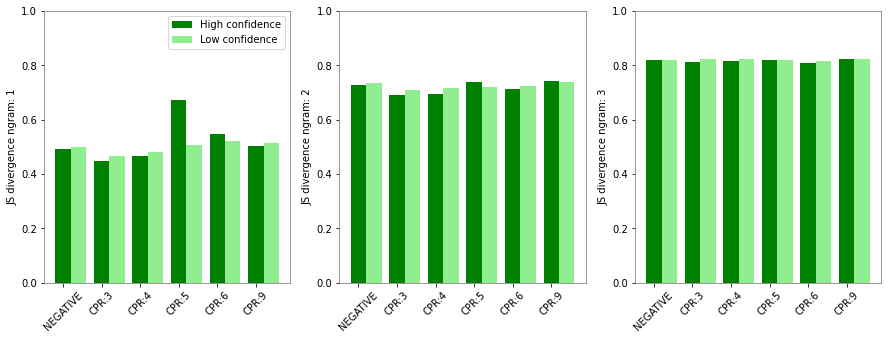

In [81]:
import numpy as np

def compute_js_divergence(p1_model_result, p2_model_result, label_names=label_names, use_common_only=False):
    result = []
    for i, l in enumerate(label_names):
        p = js_divergence(get_top_discrimintary_keywords(p1_model_result[NAIVE_BAYES]["m"],i),
                     get_top_discrimintary_keywords(p2_model_result[NAIVE_BAYES]["m"],i),
                          use_common_only=use_common_only
                     )
        result.append({
            "label_name" : l,
            "label_index" : i,
            "kl" : p
        })
    return pd.DataFrame(result)
        
def plot_divergence(df1,t1, df2, t2, ax, suffix_y_label):
    ind = np.array([float(i) for i in df1["label_index"].values] )
    width = 0.4
    
    ax.bar(ind, df1["kl"], width, color='green', label=t1)
    ax.bar(ind + width,  df2["kl"], width, color='lightgreen', label=t2)
    
    ax.legend()
    
    ax.set_xticks(df1["label_index"].values)
    ax.set_xticklabels(df1["label_name"], rotation = 45)
    
    ax.set_ylim(0,1)
    
    ax.set_ylabel(f"JS divergence {suffix_y_label}")
    
    ax.spines['bottom'].set_color('grey')
    ax.spines['top'].set_color('grey') 
    ax.spines['right'].set_color('grey')
    ax.spines['left'].set_color('grey')

        

_, axes= plt.subplots(1,3, figsize=(15,5))  

classifiers = {NAIVE_BAYES}

kwargs = {
    "ngram_range":(1,1),
    "min_df": 5,
    "stop_words": 'english',
    "classifiers":classifiers,
    "classwise_vocab":False,
    "max_words_per_class" :  5000
}

ax = axes[0]
plot_divergence(compute_js_divergence(train_and_predict_all_classifiers(df_highquality, 
                                                                       **kwargs
                                                                      ), 
                                      train_and_predict_all_classifiers(df_train, 
                                                                    **kwargs
                                                                  ),
                                      use_common_only=False
                                     ),
                "High confidence", 
                compute_js_divergence(train_and_predict_all_classifiers(df_lowquality, 
                                                                       **kwargs
                                                                      ), 
                                      train_and_predict_all_classifiers(df_train, 
                                                                   **kwargs
                                                                  ), 
                                      use_common_only=False
                                     ),
                "Low confidence",
                ax,
               "ngram: 1")
# ax = axes[1][0]
# plot_divergence(compute_kl_divergence(train_and_predict_all_classifiers(df_highquality, 
#                                                                        **kwargs
#                                                                       ), 
#                                       train_and_predict_all_classifiers(df_train, 
#                                                                     **kwargs
#                                                                   ),
#                                        use_common_only=True
#                                      ),
#                 "High confidence", 
#                 compute_kl_divergence(train_and_predict_all_classifiers(df_lowquality, 
#                                                                        **kwargs
#                                                                       ), 
#                                       train_and_predict_all_classifiers(df_train, 
#                                                                    **kwargs
#                                                                   ), 
#                                       use_common_only=True
#                                      ),
#                 "Low confidence",
#                 ax)




kwargs = {
    "ngram_range":(2,2),
    "min_df": 5,
    "stop_words":'english',
    "classifiers":classifiers,
    "classwise_vocab":False,
    "max_words_per_class" :  2000
}

ax = axes[1]
plot_divergence(compute_js_divergence(train_and_predict_all_classifiers(df_highquality, 
                                                                       **kwargs
                                                                      ), 
                                      train_and_predict_all_classifiers(df_train, 
                                                                    **kwargs
                                                                  ),
                                      use_common_only=False
                                     ),
                "High confidence", 
                compute_js_divergence(train_and_predict_all_classifiers(df_lowquality, 
                                                                       **kwargs
                                                                      ), 
                                      train_and_predict_all_classifiers(df_train, 
                                                                   **kwargs
                                                                  ),
                                       use_common_only=False
                                     ),
                "Low confidence",
                ax, "ngram: 2")

ax.legend().remove()
# ax = axes[1][1]
# plot_divergence(compute_kl_divergence(train_and_predict_all_classifiers(df_highquality, 
#                                                                        **kwargs
#                                                                       ), 
#                                       train_and_predict_all_classifiers(df_train, 
#                                                                     **kwargs
#                                                                   ),
#                                        use_common_only=True
#                                      ),
#                 "High confidence", 
#                 compute_kl_divergence(train_and_predict_all_classifiers(df_lowquality, 
#                                                                        **kwargs
#                                                                       ), 
#                                       train_and_predict_all_classifiers(df_train, 
#                                                                    **kwargs
#                                                                   ), 
#                                       use_common_only=True
#                                      ),
#                 "Low confidence",
#                 ax)
# ax.legend().remove()



kwargs = {
    "ngram_range":(3,3),
   "min_df": 5,
   "stop_words":'english',
    "classifiers":classifiers,
    "max_words_per_class" :  2000,
    "classwise_vocab":False
}

ax = axes[2]
plot_divergence(compute_js_divergence(train_and_predict_all_classifiers(df_highquality, 
                                                                       **kwargs
                                                                      ), 
                                      train_and_predict_all_classifiers(df_train, 
                                                                    **kwargs
                                                                  ),
                                       use_common_only=False
                                     ),
                "High confidence", 
                compute_js_divergence(train_and_predict_all_classifiers(df_lowquality, 
                                                                       **kwargs
                                                                      ), 
                                      train_and_predict_all_classifiers(df_train, 
                                                                   **kwargs
                                                                  ), 
                                      use_common_only=False
                                     ),
                "Low confidence",
                ax, "ngram: 3")

ax.legend().remove()


# ax = axes[1][2]
# plot_divergence(compute_kl_divergence(train_and_predict_all_classifiers(df_highquality, 
#                                                                        **kwargs
#                                                                       ), 
#                                       train_and_predict_all_classifiers(df_train, 
#                                                                     **kwargs
#                                                                   ),
#                                        use_common_only=True
#                                      ),
#                 "High confidence", 
#                 compute_kl_divergence(train_and_predict_all_classifiers(df_lowquality, 
#                                                                        **kwargs
#                                                                       ), 
#                                       train_and_predict_all_classifiers(df_train, 
#                                                                    **kwargs
#                                                                   ), 
#                                       use_common_only=True
#                                      ),
#                 "Low confidence",
#                 ax)

#ax.legend().remove()

In [82]:
from sklearn.feature_extraction.text import CountVectorizer
import warnings

def classwise_jacq(df1, df2, label_names=label_names,
                   stop_words=None, 
                   max_words_per_class=3000,
                   min_df=5,
                  ngram_range=(1,1)):
    result = []
    for i,l in enumerate(label_names):
        df1_sub = df1.query(f"y=={i}")
        df2_sub = df2.query(f"y=={i}")
        
        

        cv = CountVectorizer(stop_words=stop_words, max_features=max_words_per_class, min_df=min_df,
                             ngram_range=ngram_range,
                             analyzer='word')
        
        try:
        
            v1 = cv.fit(df1_sub["x"]).vocabulary_
            v2 = cv.fit(df2_sub["x"]).vocabulary_







            score = jaccard(v1,v2)

            result.append({

                "score" : score,
                "v1" : v1,
                "v2": v2,
                "union": set(v1).union(set(v2)),
                "intersection": set(v1).intersection(set(v2)),
                "onlyv2": set(v2)-set(v1),
                "onlyv1": set(v1)-set(v2)


            })
        except ValueError as e:
            warnings.warn(l + " - "+ str(e))
    return result
kwargs = {
    "ngram_range":(3,3),
    "min_df": 5,
    "stop_words":'english',   
    "max_words_per_class" :  2000
}




high_jq_result = classwise_jacq(df_highquality, df_train, **kwargs)
              
low_jq_result = classwise_jacq(df_lowquality, df_train, **kwargs)

/var/folders/7v/5_mr86mx7l9g94fxzdpdx0nw0000gn/T/ipykernel_70851/1408049879.py:46: UserWarning: CPR:5 - After pruning, no terms remain. Try a lower min_df or a higher max_df.
  warnings.warn(l + " - "+ str(e))


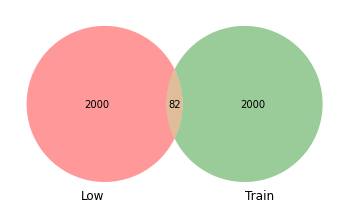

In [83]:
from matplotlib_venn import venn2

def plot_venn( score):
    venn2(subsets = (len(score[1]["v1"])
                     , len(score[1]["v2"])
                     , len(score[1]["intersection"])
                    ), 
          set_labels = ('Low', 'Train'))
    plt.show()

plot_venn(low_jq_result)

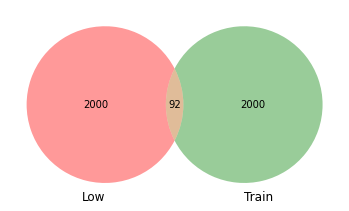

In [84]:
plot_venn(high_jq_result)

In [85]:
print(high_jq_result[0]["intersection"])

{'mb 231 cells', 'play important role', 'blood brain barrier', 'squamous cell carcinoma', 'surface plasmon resonance', 'dose response curve', 'breast cancer cells', 'taken results suggest', 'present study investigate', 'emission tomography pet', 'colon cancer cells', 'wild type geneig5', 'umbilical vein endothelial', 'positron emission tomography', 'polymerase chain reaction', 'carcinoma cell line', 'green fluorescent protein', 'previous studies demonstrated', 'play important roles', 'non small cell', 'structure activity relationships', 'transcriptase polymerase chain', 'smooth muscle cells', 'anti inflammatory effects', 'positive allosteric modulators', 'dose dependent increase', 'high fat diet', 'wild type geneig6', 'plays major role', 'mda mb 231', '10 mg kg', 'mrna protein levels', 'cell lung cancer', 'central nervous cns', '30 mg kg', 'long term potentiation', 'open reading frame', 'mitochondrial membrane potential', 'small cell lung', 'ray crystal structure', 'wild type mice', 'c

## Latex results

In [86]:
def prepare_latex(meta_dict_df, index_filter=None):
    result = []
    model_names = {NAIVE_BAYES: "NB",
                  NAIVE_BAYES_WITH_TREE:"NT",
                  TREE : "T"
    }
    label_names_map = {i:l for i,l in  enumerate(label_names)}

    for item in meta_dict_df:
        df= item.pop("df")
        if index_filter:
            df = df[df["index"].isin(index_filter)].copy(deep=True)
        df["model"] = df["model"].apply(lambda x: model_names[x])
        for i, meta in enumerate(item["meta"]):
            df.insert(i, meta["name"], meta["value"])
        df["index"] = df["index"].apply(lambda x: label_names_map.get(x,x))
        result.append(df)
       
    df_summ = pd.concat(result)
    
    return df_summ
    
df_summ_train = print_report_all_classifiers(df_train["gold"], train_result, pos_labels)

df_summ_test_bp = print_report_all_classifiers(df_test_prediction["y"], result_test_bp, pos_labels)

df_summ_test_gt = print_report_all_classifiers(df_test["gold"], result_test_gt, pos_labels)

df_summ_test_gh = print_report_all_classifiers(df_highquality["y"], result_highquality_bp,  pos_labels)
#df_summ_test_high_conf = print_report_all_classifiers(df_high_quality["y"], result_test_gt, all_labels)


df_summ = prepare_latex ([
    {"df": df_summ_train, "meta":[{ "name": "dataset" , "value": "CHM TR"}, { "name": "T" , "value": "GT"}]},
    {"df": df_summ_test_gt, "meta":[{ "name": "dataset" , "value": "CHM TS"}, { "name": "T" , "value": "GT"}]},
    {"df": df_summ_test_bp, "meta":[{ "name": "dataset" , "value": "CHM TS"}, { "name": "T" , "value": "BP"}]},
    {"df": df_summ_test_gh, "meta":[{ "name": "dataset" , "value": "CHM GH"}, { "name": "T" , "value": "BP"}]}

                ]
              )

print(df_summ.to_latex(index=False, formatters = {"precision": float_percent_format, "recall":float_percent_format, "f1-score":float_percent_format,"support":int_format}))

\begin{tabular}{llrrrr}
\toprule
             model &        index & precision & recall & f1-score & support \\
\midrule
       Naive Bayes &            1 &      58.7 &   55.3 &     57.0 &     777 \\
       Naive Bayes &            2 &      58.9 &   71.3 &     64.5 &    2260 \\
       Naive Bayes &            3 &      80.4 &   47.4 &     59.6 &     173 \\
       Naive Bayes &            4 &      70.7 &   45.1 &     55.1 &     235 \\
       Naive Bayes &            5 &      73.5 &   31.2 &     43.8 &     727 \\
       Naive Bayes &    micro avg &      61.0 &   58.9 &     59.9 &    4172 \\
       Naive Bayes &    macro avg &      68.4 &   50.1 &     56.0 &    4172 \\
       Naive Bayes & weighted avg &      63.0 &   58.9 &     58.8 &    4172 \\
Naive Bayes + Tree &            1 &      59.2 &   58.4 &     58.8 &     777 \\
Naive Bayes + Tree &            2 &      71.9 &   59.2 &     64.9 &    2260 \\
Naive Bayes + Tree &            3 &       0.0 &    0.0 &      0.0 &     173 \\
Naive Baye

In [87]:
df_summ_trainfit_test_bp = print_report_all_classifiers(df_test_prediction["y"], result_train_predict_test_bp,  all_labels)
df_summ_trainfit_test_gt = print_report_all_classifiers(df_test["gold"], result_train_predict_test_gt,  all_labels)

df_summ_train = print_report_all_classifiers(df_train["y"], train_result, all_labels)





df_summ_neg = prepare_latex ([
                    {"df": df_summ_train, "meta":[{ "name": "dataset" , "value": "CHM TR"}, { "name": "T" , "value": "GT"}]},


                {"df": df_summ_trainfit_test_gt, "meta":[{ "name": "dataset" , "value": "CHM TS"}, { "name": "T" , "value": "GT"}]},
                {"df": df_summ_trainfit_test_bp, "meta":[{ "name": "dataset" , "value": "CHM TS"}, { "name": "T" , "value": "BP"}]},
               



                ],
    index_filter=[0]
              )

print("**0***")
print(df_summ_neg.to_latex(index=False, formatters = {"precision": float_percent_format, "recall":float_percent_format, "f1-score":float_percent_format,"support":int_format}))

df_summ_phos = prepare_latex ([
                        {"df": df_summ_train, "meta":[{ "name": "dataset" , "value": "PTM TR"}, { "name": "T" , "value": "GT"}]},


                {"df": df_summ_trainfit_test_gt, "meta":[{ "name": "dataset" , "value": "PTM TS"}, { "name": "T" , "value": "GT"}]},
                {"df": df_summ_trainfit_test_bp, "meta":[{ "name": "dataset" , "value": "PTM TS"}, { "name": "T" , "value": "BP"}]},
             




                ],
    index_filter=[2]
              )

print("**2***")

print(df_summ_phos.to_latex(index=False, formatters = {"precision": float_percent_format, "recall":float_percent_format, "f1-score":float_percent_format,"support":int_format}))

\begin{tabular}{llrrrr}
\toprule
             model &        index & precision & recall & f1-score & support \\
\midrule
       Naive Bayes &            0 &      55.7 &   59.9 &     57.7 &    2018 \\
       Naive Bayes &            1 &      53.1 &   39.7 &     45.4 &     771 \\
       Naive Bayes &            2 &      47.2 &   67.8 &     55.7 &    1725 \\
       Naive Bayes &            3 &      71.2 &   26.5 &     38.7 &     196 \\
       Naive Bayes &            4 &      60.7 &   27.3 &     37.7 &     300 \\
       Naive Bayes &            5 &      64.6 &   27.7 &     38.7 &     734 \\
       Naive Bayes &     accuracy &      52.6 &   52.6 &     52.6 &       0 \\
       Naive Bayes &    macro avg &      58.8 &   41.5 &     45.7 &    5744 \\
       Naive Bayes & weighted avg &      54.7 &   52.6 &     51.3 &    5744 \\
Naive Bayes + Tree &            0 &      49.7 &   73.2 &     59.2 &    2018 \\
Naive Bayes + Tree &            1 &      53.5 &   42.4 &     47.3 &     771 \\
Naive Baye

In [88]:
print(len(result_test_bp[NAIVE_BAYES]["m"].vocab))

315


In [89]:
def prepare_latex_2(meta_dict_df, index_filter=None):
    result = []
    model_names = {NAIVE_BAYES: "NB",
                  NAIVE_BAYES_WITH_TREE:"NBT",
                  TREE : "T"
    }

    for item in meta_dict_df:
        df= item.pop("df")
        df = df.copy(deep=True)
        if index_filter:
            df = df[df["index"].isin(index_filter)].copy(deep=True)
        df["model"] = df["model"].apply(lambda x: model_names[x])
        for i, meta in enumerate(item["meta"]):
            df.insert(i, meta["name"], meta["value"])
        result.append(df)
    df_summ = pd.concat(result)
    df_summ["index"] = df_summ["index"].apply(lambda x: label_names[int(x)] if isint(x) else x )
    
    return df_summ
    
df_summ_train = print_report_all_classifiers(df_train["gold"], train_result, all_labels)

df_summ_test_bp = print_report_all_classifiers(df_test_prediction["y"], result_test_bp, all_labels)

df_summ_test_gt = print_report_all_classifiers(df_test["gold"], result_test_gt, all_labels)



df_summ = prepare_latex_2 ([
    {"df": df_summ_train, "meta":[{ "name": "dataset" , "value": "CHM TR"}, { "name": "T" , "value": "GT"}]},
    {"df": df_summ_test_gt, "meta":[{ "name": "dataset" , "value": "CHM TS"}, { "name": "T" , "value": "GT"}]},
    {"df": df_summ_test_bp, "meta":[{ "name": "dataset" , "value": "CHM TS"}, { "name": "T" , "value": "BP"}]},
                ]
              )

print(df_summ.to_latex(index=False, formatters = {"precision": float_percent_format, "recall":float_percent_format, "f1-score":float_percent_format,"support":int_format}))

\begin{tabular}{llrrrr}
\toprule
             model &        index & precision & recall & f1-score & support \\
\midrule
       Naive Bayes &            0 &      60.4 &   64.2 &     62.3 &    2265 \\
       Naive Bayes &            1 &      58.7 &   55.3 &     57.0 &     777 \\
       Naive Bayes &            2 &      58.9 &   71.3 &     64.5 &    2260 \\
       Naive Bayes &            3 &      80.4 &   47.4 &     59.6 &     173 \\
       Naive Bayes &            4 &      70.7 &   45.1 &     55.1 &     235 \\
       Naive Bayes &            5 &      73.5 &   31.2 &     43.8 &     727 \\
       Naive Bayes &     accuracy &      60.8 &   60.8 &     60.8 &       0 \\
       Naive Bayes &    macro avg &      67.1 &   52.4 &     57.1 &    6437 \\
       Naive Bayes & weighted avg &      62.1 &   60.8 &     60.0 &    6437 \\
Naive Bayes + Tree &            0 &      53.9 &   77.4 &     63.6 &    2265 \\
Naive Bayes + Tree &            1 &      59.2 &   58.4 &     58.8 &     777 \\
Naive Baye